In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 1000)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
# we load 2020 data, and later we will create a dense format data which is easier to aggregate 
k_2020 = pd.read_csv(r'/kaggle/input/kaggle-survey-2020/kaggle_survey_2020_responses.csv')
k_2020_adj = pd.DataFrame()

## Now that I say Kaggle Survey is biased, are you surprised 🙀? I'm sorry but truly, there is nothing wrong with the survey itself, it's just no survey is flawless. Here are some reasons:
* The survey sample is the Kaggle user. And the Kaggle users are active learners. They 📙, 📝, ⌨️ and they 🌱🔜🌿🔜🌻. They may locate in the upper quartile of the population and don't represent the true 📊 of interest, data scientists, data engineers, you name it.
* Say what if we are in the perfect 🌎? Nah it's not gonna happen, and you know, not everybody has the time or even willingness to finish a survey with 39 choices, 39 😨??!! Yes it is.
* Well, and a lot of them are multiple selections, ok, please select all that apply so that we can get better data 🙌🙌🙌! But w8, I don't find my choice then what should I do now?
* Besides, sometimes people would like to take the survey but they just wanna get the shxt done ASAP. Curious how fast? Like really really fast, like 🏃, 🐆, 🏎️, 🚅, 🛫 (and it's shown below).

## However, the Kaggle Survey has so much information and aspects we can explore! It's truly awesome! Yea I know I said it's biased, but maybe I'm biased too, and at least we can explore the following two points:
* What Kagglers think important. Believe me or not, it's the truth that what human see and choose is what they think important to them. 
* Kagglers' growth mindset, from 🌱 to 🌻. It's the 🔑 to data scientists, and the only path to anything and anybody right? 

## Here are the 39 Survey Questions:
#### (It took me 28 scrolls to the bottom lol, test yours, and don't forget to read the questions!)

In [4]:
# collect all questions and descriptions into a dictionary
questions = dict(zip(k_2020.columns.tolist(), k_2020.iloc[0, :].tolist()))

# better print thess questions as future reference
for question, description in questions.items():
    print('{}  ===>  {} \n'.format(question, description))

Time from Start to Finish (seconds)  ===>  Duration (in seconds) 

Q1  ===>  What is your age (# years)? 

Q2  ===>  What is your gender? - Selected Choice 

Q3  ===>  In which country do you currently reside? 

Q4  ===>  What is the highest level of formal education that you have attained or plan to attain within the next 2 years? 

Q5  ===>  Select the title most similar to your current role (or most recent title if retired): - Selected Choice 

Q6  ===>  For how many years have you been writing code and/or programming? 

Q7_Part_1  ===>  What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python 

Q7_Part_2  ===>  What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - R 

Q7_Part_3  ===>  What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - SQL 

Q7_Part_4  ===>  What programming languages do you use on a regular basis? (Select all that ap

In [5]:
# here we delete the first row, which are the questions itself
k_2020 = k_2020.iloc[1:, :]

In [6]:
# here I list all the functions potentially being used later
def change_col_dtype(df, col='', dtype=str):
    """
    Change the data type of a column
    
    Args:
        df (pd.DataFrame): the dataset
        col (str): the column name
        dtype (dtype): the expected data type, e.g. str, float
    
    Return:
        The column with the expected dtype
    """
    assert col in df.columns.tolist(), col+'is not found in the data...'
    
    return df[col].astype(dtype)
    
def to_dense_col(df, q_number='', questions=questions):
    """
    Convert a multiple-choices question from a sparse format into a dense format. 
    e.g. Select cloud services you regularly use (select all that apply)
       | GCP | Azure | AWS |            | cloud_service |
         NaN   Azure   AWS    ====>         Azure|AWS 
         NaN    NaN    AWS                     AWS   
    
    Args:
        df (pd.DataFrame): the dataset
        q_number (string): the question number. e.g. for the 5th question question='Q5' 
        questions: all the questions in the survey
        
    Returns:
        The dense column
    """
    cols = []
    for q in questions.keys():
        if q_number in q:
            cols.append(q)

    return df.apply(lambda x: '|'.join([x[col].strip() for col in cols if str(x[col]) != 'nan']), axis=1)

def get_ratio_of_people(df, col):
    """
    Get the ratios of people in each category
    
    Args:
        df (pd.DataFrame): the dataset
        col (string): the column name you want to focus on
    
    Returns:
        Aggregated dataset in pd.Series
    
    """
    freq = pd.Series('|'.join(df.loc[~df[col].isin(['', 'None']), col].astype(str).tolist()).split('|')).value_counts().reset_index().rename(columns={'index':col, 0:'freq'})
    output = freq.sort_values(by=['freq'], ascending=False)
    output['ratio'] = output['freq']/df.shape[0]
    return output

In [7]:
###### Q0. Time from Start to Finish (seconds)
k_2020_adj['t_survey'] = change_col_dtype(k_2020, col='Time from Start to Finish (seconds)', dtype=int)

# Q1. What is your age?
k_2020_adj['age'] = change_col_dtype(k_2020, col='Q1', dtype='O')

# Q2. What is your gender?
k_2020_adj['gender'] = change_col_dtype(k_2020, col='Q2', dtype='O')

# Q3. In which country do you currently reside?
k_2020_adj['country'] = change_col_dtype(k_2020, col='Q3', dtype='O')

# Q4. What is the highest level of formal education that you have attained or plan to attain within the next 2 years?
k_2020_adj['formal_edu'] = change_col_dtype(k_2020, col='Q4', dtype='O')

# Q5. Select the title most similar to your current role (or most recent title if retired)
k_2020_adj['job_title'] = change_col_dtype(k_2020, col='Q5', dtype='O')

# Q6. For how many years have you been writing code and/or programming?
k_2020_adj['code_exp'] = change_col_dtype(k_2020, col='Q6', dtype='O')

# Q7. What programming languages do you use on a regular basis? (Select all that apply)
k_2020_adj['language'] = to_dense_col(k_2020, q_number='Q7')

# Q8. What programming language would you recommend an aspiring data scientist to learn first?
k_2020_adj['rec_learn'] = change_col_dtype(k_2020, col='Q8', dtype='O')

# Q9. Which of the following integrated development environments (IDE's) do you use on a regular basis? (Select all that apply)
k_2020_adj['ide'] = to_dense_col(k_2020, q_number='Q9')

# Q10. Which of the following hosted notebook products do you use on a regular basis? (Select all that apply)
k_2020_adj['notebook'] = to_dense_col(k_2020, q_number='Q10')

# Q11. What type of computing platform do you use most often for your data science projects?
k_2020_adj['comp_plfm'] = change_col_dtype(k_2020, col='Q11', dtype='O')

# Q12. Which types of specialized hardware do you use on a regular basis? (Select all that apply)
k_2020_adj['hardware'] = to_dense_col(k_2020, q_number='Q12')

# Q13. Approximately how many times have you used a TPU (tensor processing unit)?
k_2020_adj['num_use_TPU'] = change_col_dtype(k_2020, col='Q13', dtype='O')

# Q14. What data visualization libraries or tools do you use on a regular basis? (Select all that apply)
k_2020_adj['lib_visual'] = to_dense_col(k_2020, q_number='Q14')

# Q15. For how many years have you used machine learning methods?
k_2020_adj['ml_exp'] = change_col_dtype(k_2020, col='Q15', dtype='O')

# Q16. Which of the following machine learning frameworks do you use on a regular basis? (Select all that apply)
k_2020_adj['ml_framework'] = to_dense_col(k_2020, q_number='Q16')

# Q17. Which of the following ML algorithms do you use on a regular basis? (Select all that apply):
k_2020_adj['ml_alg'] = to_dense_col(k_2020, q_number='Q17')

# Q18. Which categories of computer vision methods do you use on a regular basis? (Select all that apply)
k_2020_adj['cv'] = to_dense_col(k_2020, q_number='Q18')

# Q19. Which of the following natural language processing (NLP) methods do you use on a regular basis? (Select all that apply)
k_2020_adj['nlp'] = to_dense_col(k_2020, q_number='Q19')

# Q20. What is the size of the company where you are employed?
k_2020_adj['employer_size'] = k_2020['Q20']

# Q21. Approximately how many individuals are responsible for data science workloads at your place of business?
k_2020_adj['bus_ds_size'] = k_2020['Q21']

# Q22. Does your current employer incorporate machine learning methods into their business?
k_2020_adj['employer_ml_stage'] = k_2020['Q22']

# Q23. Select any activities that make up an important part of your role at work: (Select all that apply)
k_2020_adj['jd'] = to_dense_col(k_2020, q_number='Q23')

# Q24. What is your current yearly compensation (approximate $USD)?
k_2020_adj['annual_comp'] = change_col_dtype(k_2020, col='Q24', dtype='O')

# Q25. Approximately how much money have you (or your team) spent on machine learning and/or cloud computing services at home (or at work) in the past 5 years (approximate $USD)?
k_2020_adj['ml_cost_prev_5_year'] = k_2020['Q25']

# Q26-A. Which of the following cloud computing platforms do you use on a regular basis? (Select all that apply)
k_2020_adj['cloud_plfm'] = to_dense_col(k_2020, q_number='Q26_A')

# Q27-A. Do you use any of the following cloud computing products on a regular basis? (Select all that apply) (Q27-A were asked given Q26-A)
k_2020_adj['cloud_compute'] = to_dense_col(k_2020, q_number='Q27_A')

# Q28-A. Do you use any of the following machine learning products on a regular basis? (Select all that apply) (Q28-A were asked given Q26-A)
k_2020_adj['cloud_ml'] = to_dense_col(k_2020, q_number='Q28_A')

# Q29-A. Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you use on a regular basis? (Select all that apply)
k_2020_adj['big_data'] = to_dense_col(k_2020, q_number='Q29_A')

# Q30. Which of the following big data products (relational database, data warehouse, data lake, or similar) do you use most often?
#print('Q30 were asked given Q29-A\n')
k_2020_adj['big_data_tool'] = change_col_dtype(k_2020, col='Q30', dtype='O')

# Q31-A. Which of the following business intelligence tools do you use on a regular basis? (Select all that apply)
k_2020_adj['bus_intel'] = to_dense_col(k_2020, q_number='Q31_A')

# Q32. Which of the following business intelligence tools do you use most often? (Q32 were asked given Q31-A)
k_2020_adj['bus_intel_tool'] = change_col_dtype(k_2020, col='Q32', dtype='O')

# Q33-A. Do you use any automated machine learning tools (or partial AutoML tools) on a regular basis? (Select all that apply)
k_2020_adj['auto_ml'] = to_dense_col(k_2020, q_number='Q33_A')

# Q34-A. Which of the following automated machine learning tools (or partial AutoML tools) do you use on a regular basis? (Select all that apply)(Q34-A were asked given Q33-A)
k_2020_adj['auto_ml_tool'] = to_dense_col(k_2020, q_number='Q34_A')

# Q35-A. Do you use any tools to help manage machine learning experiments? (Select all that apply)
k_2020_adj['ml_exp_mngmt'] = to_dense_col(k_2020, q_number='Q35_A')

# Q36. Where do you publicly share or deploy your data analysis or machine learning applications? (Select all that apply)
k_2020_adj['share_plfm'] = to_dense_col(k_2020, q_number='Q36')

# Q37. On which platforms have you begun or completed data science courses? (Select all that apply)
k_2020_adj['ds_course_plfm'] = to_dense_col(k_2020, q_number='Q37')

# Q38. What is the primary tool that you use at work or school to analyze data? (Include text response)
k_2020_adj['prime_analytical_tool'] = change_col_dtype(k_2020, col='Q38', dtype='O')

# Q39. Who/what are your favorite media sources that report on data science topics? (Select all that apply)
k_2020_adj['ds_media'] = to_dense_col(k_2020, q_number='Q39')

# Q26-B.Which of the following cloud computing platforms do you hope to become more familiar with in the next 2 years?
k_2020_adj.loc[lambda x: (x['ml_cost_prev_5_year'].isnull()) | (x['ml_cost_prev_5_year'] == '$0 ($USD)'), 'cloud_plfm'] = to_dense_col(k_2020.loc[lambda x: (x['Q25'].isnull()) | (x['Q25'] == '$0 ($USD)')], q_number='Q26_B')

# Q27-B. In the next 2 years, do you hope to become more familiar with any of these specific cloud computing products? (Select all that apply)
k_2020_adj.loc[lambda x: (x['ml_cost_prev_5_year'].isnull()) | (x['ml_cost_prev_5_year'] == '$0 ($USD)'), 'cloud_compute'] = to_dense_col(k_2020.loc[lambda x: (x['Q25'].isnull()) | (x['Q25'] == '$0 ($USD)')], q_number='Q27_B')

# Q28-B. In the next 2 years, do you hope to become more familiar with any of these specific machine learning products? (Select all that apply)
k_2020_adj.loc[lambda x: (x['ml_cost_prev_5_year'].isnull()) | (x['ml_cost_prev_5_year'] == '$0 ($USD)'), 'cloud_ml'] = to_dense_col(k_2020.loc[lambda x: (x['Q25'].isnull()) | (x['Q25'] == '$0 ($USD)')], q_number='Q28_B')

# Q29-B. Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you hope to become more familiar with in the next 2 years? (Select all that apply)
k_2020_adj.loc[lambda x: (x['ml_cost_prev_5_year'].isnull()) | (x['ml_cost_prev_5_year'] == '$0 ($USD)'), 'big_data'] = to_dense_col(k_2020.loc[lambda x: (x['Q25'].isnull()) | (x['Q25'] == '$0 ($USD)')], q_number='Q29_B')

# Q31-B. Which of the following business intelligence tools do you hope to become more familiar with in the next 2 years? (Select all that apply)
k_2020_adj.loc[lambda x: (x['ml_cost_prev_5_year'].isnull()) | (x['ml_cost_prev_5_year'] == '$0 ($USD)'), 'bus_intel'] = to_dense_col(k_2020.loc[lambda x: (x['Q25'].isnull()) | (x['Q25'] == '$0 ($USD)')], q_number='Q31_B')

# Q33-B. Which categories of automated machine learning tools (or partial AutoML tools) do you hope to become more familiar with in the next 2 years? (Select all that apply)
k_2020_adj.loc[lambda x: (x['ml_cost_prev_5_year'].isnull()) | (x['ml_cost_prev_5_year'] == '$0 ($USD)'), 'auto_ml'] = to_dense_col(k_2020.loc[lambda x: (x['Q25'].isnull()) | (x['Q25'] == '$0 ($USD)')], q_number='Q33_B')

# Q34-B. Which specific automated machine learning tools (or partial AutoML tools) do you hope to become more familiar with in the next 2 years? (Select all that apply)
k_2020_adj.loc[lambda x: (x['ml_cost_prev_5_year'].isnull()) | (x['ml_cost_prev_5_year'] == '$0 ($USD)'), 'auto_ml_tool'] = to_dense_col(k_2020.loc[lambda x: (x['Q25'].isnull()) | (x['Q25'] == '$0 ($USD)')], q_number='Q34_B')

# Q35-B. In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments? (Select all that apply)
k_2020_adj.loc[lambda x: (x['ml_cost_prev_5_year'].isnull()) | (x['ml_cost_prev_5_year'] == '$0 ($USD)'), 'ml_exp_mngmt'] = to_dense_col(k_2020.loc[lambda x: (x['Q25'].isnull()) | (x['Q25'] == '$0 ($USD)')], q_number='Q35_B')

## Like I promised to show how fast a Kaggler can be to finish a survey, here is the answer: 20 seconds
* I think they quitted the survey in half becuase 20/39 = 0.51s/question is impossible.
* Finish time that is too short won't be considered, you know, the time when we choose the answers before thinking, jump around and leave them blank, and treat the survey just as getting a trivial thing done. The 😎 feels not right.
* So here we make an assumption that to make sure the survey validity, the minimal time of reading/answering a question in second is 5, total is expected to be 5 * 39 = 195 seconds

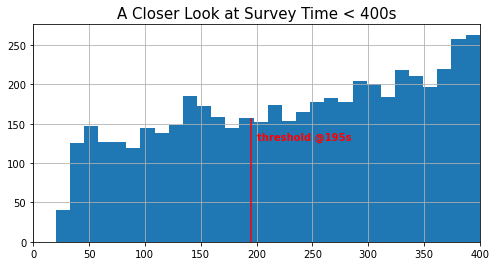

In [8]:
# time in minutes
# assume avg. min time in second per question is 5, total is expected to be 5 * 35 = 175 seconds
k_2020 = k_2020.rename(columns={'Time from Start to Finish (seconds)': 't_survey'})
k_2020['t_survey'] = k_2020['t_survey'].astype(int)

plt.figure(figsize=(8, 4))
plt.xlim(0, 400)
(k_2020.loc[lambda x: x['t_survey'] <= 400]['t_survey']).hist(bins=30)
plt.title('A Closer Look at Survey Time < 400s', fontsize=15)
plt.axvline(x=195, ymax=0.565, color='red')
plt.text(x=200, y=130, s='threshold @195s', color='red', fontsize='medium', fontfamily='fantasy', fontweight='semibold')

k_2020_adj = k_2020_adj.loc[lambda x: x['t_survey'] > 195]

In [9]:
# just make a copy 
df = k_2020_adj.copy()

## Check out how the data in the dense format look like:

In [10]:
print('Now we have {:d} surveys for further analysis.'.format(df.shape[0]))
print('Our dense data looks like this:')
df.head(2)

Now we have 18124 surveys for further analysis.
Our dense data looks like this:


,t_survey,age,gender,country,formal_edu,job_title,code_exp,language,rec_learn,ide,notebook,comp_plfm,hardware,num_use_TPU,lib_visual,ml_exp,ml_framework,ml_alg,cv,nlp,employer_size,bus_ds_size,employer_ml_stage,jd,annual_comp,ml_cost_prev_5_year,cloud_plfm,cloud_compute,cloud_ml,big_data,big_data_tool,bus_intel,bus_intel_tool,auto_ml,auto_ml_tool,ml_exp_mngmt,share_plfm,ds_course_plfm,prime_analytical_tool,ds_media
1,1838,35-39,Man,Colombia,Doctoral degree,Student,5-10 years,Python|R|SQL|C|Javascript|MATLAB|Other,Python,"Jupyter (JupyterLab, Jupyter Notebooks, etc)|V...",Kaggle Notebooks|Colab Notebooks,"A cloud computing platform (AWS, Azure, GCP, h...",GPUs,2-5 times,Matplotlib|Geoplotlib,1-2 years,TensorFlow|Keras|Xgboost,Decision Trees or Random Forests|Gradient Boos...,Image classification and other general purpose...,"Word embeddings/vectors (GLoVe, fastText, word...",NaN,NaN,NaN,,NaN,NaN,Amazon Web Services (AWS)|Microsoft Azure|Goog...,Azure Cloud Services|Microsoft Azure Container...,Amazon SageMaker|Amazon Forecast|Amazon Rekogn...,MongoDB|Microsoft SQL Server|Google Cloud BigQ...,NaN,Microsoft Power BI|Amazon QuickSight|Google Da...,NaN,"Automated data augmentation (e.g. imgaug, albu...",Google Cloud AutoML|Databricks AutoML|Auto-Ker...,TensorBoard,,Coursera|Kaggle Learn Courses|University Cours...,"Basic statistical software (Microsoft Excel, G...","Kaggle (notebooks, forums, etc)|Journal Public..."
2,289287,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,Python|R|SQL,Python,Visual Studio|PyCharm|Sublime Text,Colab Notebooks,A personal computer or laptop,GPUs,2-5 times,Matplotlib|Seaborn|Ggplot / ggplot2|Shiny,1-2 years,Scikit-learn|TensorFlow|Keras|PyTorch,Linear or Logistic Regression|Convolutional Ne...,"Image segmentation methods (U-Net, Mask R-CNN,...","Contextualized embeddings (ELMo, CoVe)|Transfo...","10,000 or more employees",20+,"We have well established ML methods (i.e., mod...",Analyze and understand data to influence produ...,"100,000-124,999","$100,000 or more ($USD)",Amazon Web Services (AWS)|Microsoft Azure|Goog...,Amazon EC2|AWS Lambda|Azure Functions|Google C...,Amazon SageMaker,PostgresSQL|Amazon Redshift|Amazon Athena,PostgresSQL,Amazon QuickSight|Microsoft Power BI|Tableau,Microsoft Power BI,No / None,,No / None,GitHub,Coursera|DataCamp|Udemy,"Business intelligence software (Salesforce, Ta...",Twitter (data science influencers)|Reddit (r/m...


## Before we jump into the following analysis, think about these two questions again 🤔:
* **Things Kagglers think important**
* **Kagglers' growth mindset**

## Last question, if annual compensation is the ☝🏼️ issue, what's more important?
* personal attributes?
* skillsets and abilities?
* career experiences?
* continuous growths?

# Take-aways and Actions 🔑🔑🔑

### Growth 🚀🚀🚀
* Focus on learning new things in the first 4 years of career. Find your job needs, build up and stick to 4-5 skills as your core 🤘🏼🤘🏼🤘🏼 to make yourself unique and standout. But don't forget to be open-minded and have some knowledge on other things
* Engage with the community and interact with others by sharing your work and learning from others, it is all-time important!

### Important Things To Note ⭐⭐⭐
* Having at least a Master's degree is important for data-related jobs, but it's becoming less important.
* Know Python 🐍, learn 🐍, master 🐍, and integrate 🐍 with the other languages you regularly use to build a network 🕸️ in your brain 🧠.
* Free services like Google Colab and Kaggle Notebook are the must to know, but don't completely ignore pay services like Amazon Sagemaker because pay 💰 means better experiences and better quality, and it might be closer to the industry needs.
* Visalization is intended to be used to deliver people's thoughts, which is beyond being fancy. It could be simple or complicate and it could be built using any tool/packages (Tableau|Matplotlib|Seaborn|Ggplot|...). However, it must be easy to understand and interactive ✨. 

### When You Consider A Higher Annual Compensation ❗❗❗
* Career experience is the most important aspect
    - One needs to know how to drive large business impacts using data and their skills.
    - One needs to know how to build things in large scale by knowing what different scales of companies or data teams are doing 👶-🧒-🧑🏼. 
* Skillsets and abilities is the 2nd important aspect
    - Plotly is strongly recommended! Or any other interactive package also works. And don't forget to know how to put it in production 📱.
    - Get to know and apply more ides, languages, visualizations, and machine learning frameworks whenever needed.
* p.s. If you are having a data job in the United States, you've been on the pirate boat ⚓-💰.


### Here I collected my findings from the analysis. Help me check it out, tell me what you think and whether they are ✔️ or ❌ with your understandings. 
* People age from 18 to 34 act as more active learners. More specifically, once they dive into a new area or career, they grow and learn really fast in the first 5 years.
* Data Scientists market lowers the bar of higher formal education (Master's or Doctor's) and become more open to Bachelor's degrees. However, Data Scientists with Master's degrees still take up the majority part of the market, which is 51.14% in 2020.
* The most regularly used language is still Python 🐍 and it's the one Kagglers think most important, no matter if they use it. People tend to use python with other one or two languages as a language combo. Popular combos are (Python|SQL), (Python|R), (Python|SQL|R), and (Python|C|C++). However, what's interesting is that for analytics (people using one of Python, R, or SQL), some think Python is very important but some think it is not at all.
* Popular two notebook platforms are Google Colab and Kaggle Notebook (ps. this is Kaggle survey anyway 🤷🏼). Both the experienced and students like to use them 🆓! As for Amazon Sagemaker, compared with students who almost don't use it at all, a lot more experienced people use it 💰. 
* Data Scientists' favorite visualization tools are Seaborn | Ggplot | Plotly | Shiny | Bokeh | Leaflet/Folium. These packages have things in common: easthetical, easy-to-use, interactive. Especially for plotly ✨, comparing with other jobs, data scientists have more than 10% of people using it.
* For machine learning and deep learning techniques in general, on average, Kagglers gain 1 skill/working year and tend to become stable after 4-5 years working experience. For more advanced techniques like Computer Vision or Natural Language Processing, people learn 1-2 skills in the first 5 years and stick with it across the career.
* Job responsibilities can be categorized into three: analytics, machine learning R&D, and pipeline/architecture. Jobs define which job responsibility you should treat more importantly. However, if you are data scientists, machine learning engineers, or research scientists, you will take multiple responsibilities. 
* The cost on Machine learning and cloud services is positively correlated to the company size 🏦, the data science team size 👥, and the company's stage of machine learning developements 🌘🌗🌒. More specifically, compared with other jobs, data scientists have the highest willingness to spend money on these services.
* Top1 platform to share work is Github. Machine learning engineers, data scientists, and data engineers have higher willingness to share work on platforms while students and the unemployeed don't share work at all. 
* The top3 course platforms are Coursera, Kaggle Learn Course, and Udemy, having 18%, 12.5%, and 12% of users, respectively. Cloud-certification Programs and Fast.ai are the two platforms having least users, which is only 2.5%.
* The top3 media sources are Kaggle, Youtube, and blogs. Students prefer the more entertaining media type like Youtube while the experienced prefer various of readable and interactive media like Kaggle and blogs.

## Business Understanding
* Data science is everywhere and it has been the sexiest job all over the world. However, it is so popular that so many advertisements are disguising what real data scientists think important and how they pursue their growth in the careers. As a consequence, students and aspiring data scientists neither exactly know how should they grow nor what they should expected themselves to be in 1 year, 2 years, and even 5 years in the future. 

## Data Understanding
* First we want to understand some personal basic attributes like **age**, **formal education**, and **location**
* Then we want to understand some work and/or job related attributes like **experience**, **job title**, **languages**, **skills**, **platforms**, and **tools**

### Some Kagglers' basic attributes are 🎂, 🎓️, 📍

In [11]:
def get_age_order(df):
    """Create age ordinal column"""
    df['age_order'] = df['age'].replace({'18-21':1, 
                                         '22-24':2, 
                                         '25-29':3, 
                                         '30-34':4, 
                                         '35-39':5, 
                                         '40-44':6, 
                                         '45-49':7, 
                                         '50-54':8, 
                                         '55-59':9, 
                                         '60-69':10, 
                                         '70+':11})
    return df

Most people's ages range from 18 to 34.


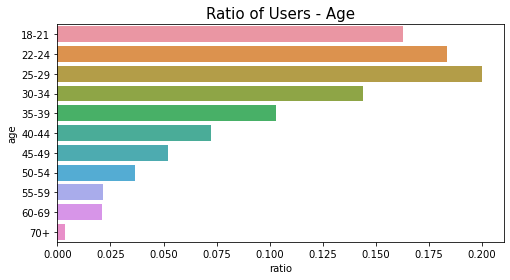

In [12]:
plt.figure(figsize=(8, 4))
age = df['age'].value_counts(normalize=True).reset_index().rename(columns={'index':'age', 'age':'ratio'})
age = get_age_order(age)

sns.barplot(data=age.sort_values(by=['age_order']), y='age', x='ratio', orient='h')
plt.title('Ratio of Users - Age', fontsize=15)
plt.xlabel('ratio')
plt.ylabel('age')
print("Most people's ages range from 18 to 34.")

In [13]:
def get_formal_edu_order(df):
    """create formal edu ordinal column"""
    df['edu_order'] = df['formal_edu'].replace({'I prefer not to answer':0, 
                                                'No formal education past high school':1,
                                                'Some college/university study without earning a bachelor’s degree':2,
                                                'Professional degree':3,
                                                'Bachelor’s degree':4,
                                                'Master’s degree':5,
                                                'Doctoral degree':6})
    
    return df

Most of the people hold Bachelor's or Master's as the highest degree, however, Doctoral degree doesn't occupy that much.


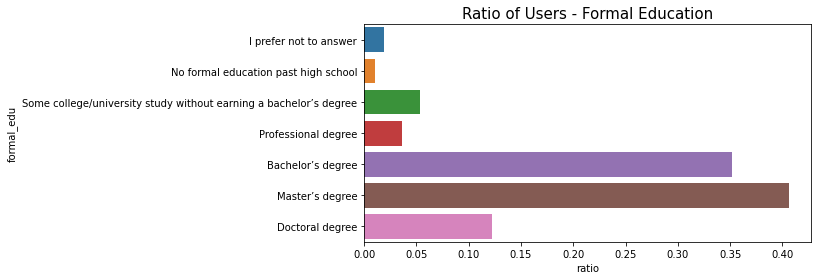

In [14]:
formal_edu = df['formal_edu'].value_counts(normalize=True).reset_index().rename(columns={'index':'formal_edu', 'formal_edu':'ratio'})
formal_edu = get_formal_edu_order(formal_edu)

plt.figure(figsize=(8, 4))
sns.barplot(data=formal_edu.sort_values(by=['edu_order']), x='ratio', y='formal_edu', orient='h')
plt.title('Ratio of Users - Formal Education', fontsize=15)
plt.xlabel('ratio')
print("Most of the people hold Bachelor's or Master's as the highest degree, however, Doctoral degree doesn't occupy that much.")

* Kagglers holding the Master's degree are still the majority of data scientists, on average 30.71% higher than Bachelor's degree and 34.77% higher than Doctor's degree.
* The ratio of data scientists holding Master's degrees or the ratio for Doctor's degrees are dropping.
* The ratio for Bachelor's degree is increasing, 2018 was 20.19% and 2020 was 24.22%, which is round 4.04% increase.


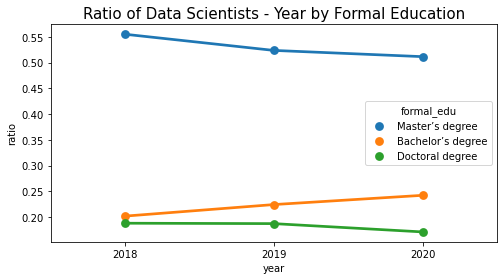

In [15]:
k_2019 = pd.read_csv(r'/kaggle/input/kaggle-survey-2019/multiple_choice_responses.csv')
k_2018 = pd.read_csv(r'/kaggle/input/kaggle-survey-2018/multipleChoiceResponses.csv')

ds_to_edu_2020 = pd.Series(k_2020.loc[lambda x: x['Q5'] == 'Data Scientist']['Q4'].values[1:]).value_counts(normalize=True).reset_index().rename(columns={'index':'formal_edu', 0:'ratio'}).iloc[:3, :]
ds_to_edu_2020.loc[:, 'year'] = 2020
ds_to_edu_2019 = pd.Series(k_2019.loc[lambda x: x['Q5'] == 'Data Scientist']['Q4'].values[1:]).value_counts(normalize=True).reset_index().rename(columns={'index':'formal_edu', 0:'ratio'}).iloc[:3, :]
ds_to_edu_2019.loc[:, 'year'] = 2019
ds_to_edu_2018 = pd.Series(k_2018.loc[lambda x: x['Q6'] == 'Data Scientist']['Q4'].values[1:]).value_counts(normalize=True).reset_index().rename(columns={'index':'formal_edu', 0:'ratio'}).iloc[:3, :]
ds_to_edu_2018.loc[:, 'year'] = 2018

ds_to_edu_by_year = pd.concat([ds_to_edu_2018, ds_to_edu_2019, ds_to_edu_2020], axis=0)
ds_to_edu_by_year

plt.figure(figsize=(8, 4))
sns.pointplot(data=ds_to_edu_by_year, x='year', y='ratio', hue='formal_edu')
plt.title('Ratio of Data Scientists - Year by Formal Education', fontsize=15)

diff_mb = ds_to_edu_by_year.loc[lambda x: x['formal_edu'].str.contains('Master')]['ratio'].mean() - ds_to_edu_by_year.loc[lambda x: x['formal_edu'].str.contains('Bachelor')]['ratio'].mean()
diff_md = ds_to_edu_by_year.loc[lambda x: x['formal_edu'].str.contains('Master')]['ratio'].mean() - ds_to_edu_by_year.loc[lambda x: x['formal_edu'].str.contains('Doctor')]['ratio'].mean()
print("* Kagglers holding the Master's degree are still the majority of data scientists, on average {:.2%} higher than Bachelor's degree and {:.2%} higher than Doctor's degree.".format(diff_mb, diff_md))
print("* The ratio of data scientists holding Master's degrees or the ratio for Doctor's degrees are dropping.")

ratio_b_2018 = ds_to_edu_by_year.loc[lambda x: (x['year'] == 2018) & (x['formal_edu'].str.contains('Bachelor'))]['ratio'].values[0]
ratio_b_2020 = ds_to_edu_by_year.loc[lambda x: (x['year'] == 2020) & (x['formal_edu'].str.contains('Bachelor'))]['ratio'].values[0]
print("* The ratio for Bachelor's degree is increasing, 2018 was {:.2%} and 2020 was {:.2%}, which is round {:.2%} increase.".format(ratio_b_2018, ratio_b_2020, ratio_b_2020 - ratio_b_2018))

* Kagglers spread everywhere across countries, that is truly amazing!
* India has the most people.
* United States is the 2nd place, having 11.24% people from United States, not that much.
* While I know in China we have so many people actively engaging Kaggle competitions, some of them are even doing Kaggle consulting, it just located number 9.


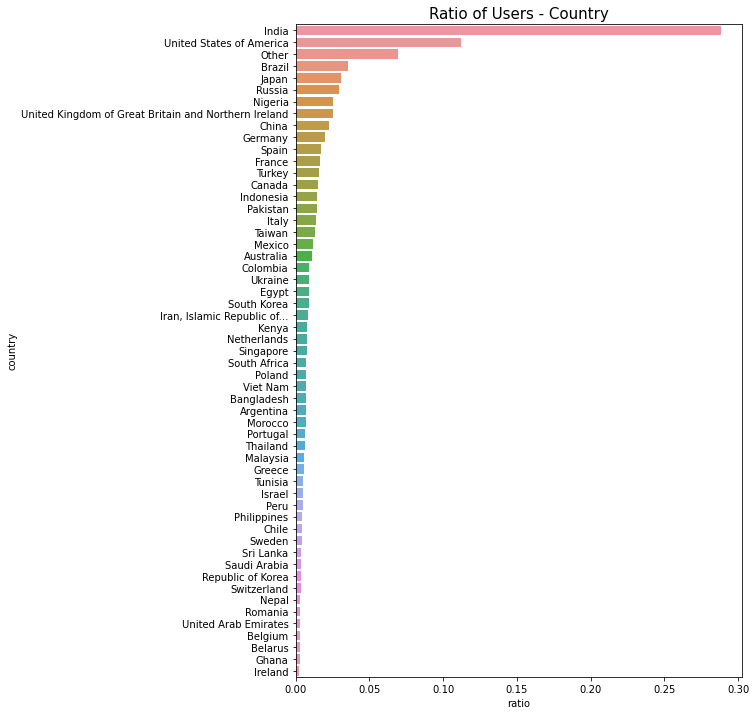

In [16]:
plt.figure(figsize=(8, 12))
plt.title('Ratio of Users - Country', fontsize=15)
country = df['country'].value_counts(normalize=True).reset_index().rename(columns={'index':'country', 'country':'ratio'})
sns.barplot(data=country, x='ratio', y='country', orient='h')
print('* Kagglers spread everywhere across countries, that is truly amazing!')
print('* India has the most people.')
print('* United States is the 2nd place, having {:.2%} people from United States, not that much.'.format(df.loc[df['country'] == 'United States of America'].shape[0]/df.shape[0]))
print('* While I know in China we have so many people actively engaging Kaggle competitions, some of them are even doing Kaggle consulting, it just located number 9.')

Students take up around 25% of the population.
Data Scientists take up around 14% of the population.


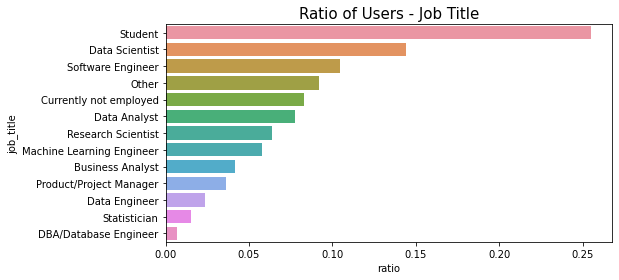

In [17]:
plt.figure(figsize=(8, 4))
plt.title('Ratio of Users - Job Title', fontsize=15)
jt = df['job_title'].value_counts(normalize=True).reset_index().rename(columns={'index':'job_title', 'job_title':'ratio'})
sns.barplot(data=jt, x='ratio', y='job_title')
print('Students take up around 25% of the population.')
print('Data Scientists take up around 14% of the population.')

In [18]:
def get_code_exp_order(df):
    """Create code experience ordinal column. new column name is 'exp_order'"""
    df['exp_order'] = df['code_exp'].replace({'I have never written code':0,
                                              '< 1 years':0.5,
                                              '1-2 years':1.5,
                                              '3-5 years':2.5,
                                              '5-10 years':3.5,
                                              '10-20 years':4.5,
                                              '20+ years':7.5})
    return df

Most people have coding experience, and most of them are between 0 and 5, that golden first 5 years!
Since Kaggle users are the portion who are willing to take action and being positive on learning, according to the data, people with 0-5 years coding experience tend to be more active.


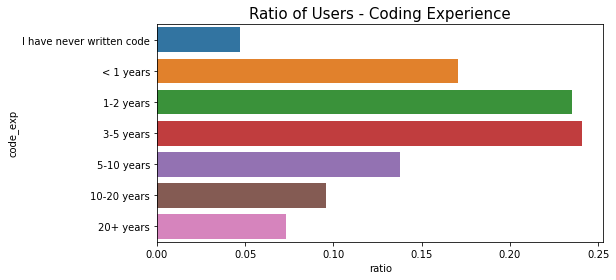

In [19]:
plt.figure(figsize=(8, 4))
plt.title('Ratio of Users - Coding Experience', fontsize=15)
code = df['code_exp'].value_counts(normalize=True).reset_index().rename(columns={'index':'code_exp', 'code_exp':'ratio'})
code = get_code_exp_order(code)

sns.barplot(data=code.sort_values(by=['exp_order']), x='ratio', y='code_exp', orient='h')
print('Most people have coding experience, and most of them are between 0 and 5, that golden first 5 years!')
print('Since Kaggle users are the portion who are willing to take action and being positive on learning, according to the data, people with 0-5 years coding experience tend to be more active.')

### The language that Kagglers think important is still 🐍, and it's not just because people use it.
* People using python think python is more important, than people don't use python. but the consistency is no matter if using python, Python, R, and SQL are top 3 recommended language to learn, which means we treat these three important.
* People don't use top3 languages at all still recommend Python, and then comes C++, while R is 5th and SQL is 7th

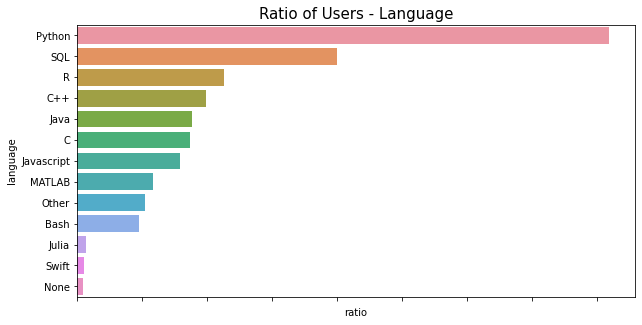

In [20]:
language = pd.Series('|'.join(df['language']).split('|')).value_counts().reset_index().rename(columns={'index':'language', 0:'num_people'})
language = language.loc[lambda x: x['language'] != '']
language['ratio'] = language['num_people'] / df['language'].shape[0]

plt.figure(figsize=(10, 5))
ax = sns.barplot(data=language, x='ratio', y='language')
ax.set_title('Ratio of Users - Language', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

In [21]:
def get_num_X(df, col='', new_col='', dropna=False):
    """
    Count the number of choices selected for a certain column. 
    e.g. if a person uses Python and SQL, the number of languages is 2
    
    Args:
        df (pd.DataFrame): the dataset
        col (string): the column name 
        new_col (string): the new column name
        dropna (bool): if drop null values
    Returns:
        df
    """
    df[new_col] = df[col].apply(lambda x: len(x.split('|')))
    if dropna:
        df.loc[df[col].isin(['', 'None', None]), new_col] = 0
    
    return df

* There are 4170 out of 18124 users solely using one language.
* There are 4877 out of 18124 users using two languages, which is the highest number
* There are 3930 out of 18124 users using three languages, after which the number of users drastically drops as the number of language increases

Since most people are using Python as the major language plus a lot of them are using one or two more languages as a combination, let's see what are the top 3 combos for pythoners.
* The top3 language combo-2:
   1. Python|SQL
   2. Python|R
   3. Python|C++
* The top3 language combo-3:
   1. Python|R|SQL
   2. Python|C|C++
   3. Python|SQL|Bash
It does show clear ds tracks: Analyst/Scientist, Developer, and Engineer? And needless to say, Python+SQL is the golden combo.


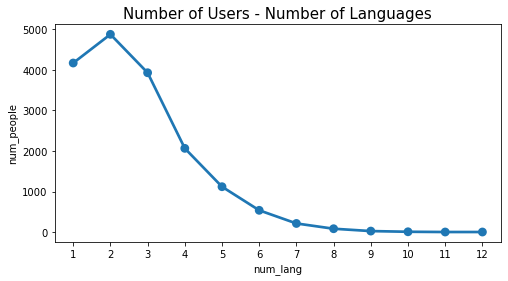

In [22]:
lang_combo = df['language'].value_counts().reset_index().rename(columns={'index':'lang_combo', 'language':'num_people'})
lang_combo = lang_combo.loc[lambda x: x['lang_combo'] != '']
lang_combo['ratio'] = lang_combo['num_people'] / df['language'].shape[0]
lang_combo = get_num_X(lang_combo, 'lang_combo', 'num_lang')

plt.figure(figsize=(8, 4))
plt.title('Number of Users - Number of Languages', fontsize=15)
sns.pointplot(data=lang_combo.groupby(['num_lang'])['num_people'].sum().reset_index(), x='num_lang', y='num_people')
print('* There are {:d} out of {:d} users solely using one language.'.format(lang_combo.groupby(['num_lang'])['num_people'].sum().reset_index().loc[lambda x: x['num_lang'] == 1, 'num_people'].values[0], df['language'].shape[0]))
print('* There are {:d} out of {:d} users using two languages, which is the highest number'.format(lang_combo.groupby(['num_lang'])['num_people'].sum().reset_index().loc[lambda x: x['num_lang'] == 2, 'num_people'].values[0], df['language'].shape[0]))
print('* There are {:d} out of {:d} users using three languages, after which the number of users drastically drops as the number of language increases'.format(lang_combo.groupby(['num_lang'])['num_people'].sum().reset_index().loc[lambda x: x['num_lang'] == 3, 'num_people'].values[0], df['language'].shape[0]))

print("\nSince most people are using Python as the major language plus a lot of them are using one or two more languages as a combination, let's see what are the top 3 combos for pythoners.")
# top combo 2
print('* The top3 language combo-2:')
for i, val in enumerate(lang_combo.loc[lambda x: x['lang_combo'].str.contains('Python')].loc[lambda x: x['num_lang'] == 2].iloc[:3]['lang_combo'].values):
    print('   {:d}. {:s}'.format(i + 1, val))

# top combo 3
print('* The top3 language combo-3:')
for i, val in enumerate(lang_combo.loc[lambda x: x['lang_combo'].str.contains('Python')].loc[lambda x: x['num_lang'] == 3].iloc[:3]['lang_combo'].values):
    print('   {:d}. {:s}'.format(i + 1, val))
print('It does show clear ds tracks: Analyst/Scientist, Developer, and Engineer? And needless to say, Python+SQL is the golden combo.')

Analytics who use other analytical languages other than Python do not think Python very important comparing people not doing analytics at all.
* Analytics may think Python can be replaced by other languages when doing data science work.
* Non-analytics may think Python is very important when doing data science work.
* Python is the good language to bridge gaps among different tracks and areas.


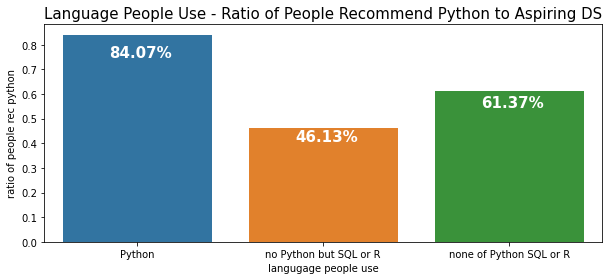

In [23]:
rec_py = pd.DataFrame([['Python', 0], ['no Python but SQL or R', 0], ['none of Python SQL or R', 0]], columns=['lang', 'ratio'])
rec_py.loc[lambda x: x['lang'] == 'Python', 'ratio'] = df.loc[df['language'].str.contains('Python')]['rec_learn'].value_counts(normalize=True).reset_index().loc[lambda x: x['index'] == 'Python', 'rec_learn'].values[0]
rec_py.loc[lambda x: x['lang'] == 'no Python but SQL or R', 'ratio'] = df.loc[(df['language'].str.contains('SQL|R')) & (~df['language'].str.contains('Python'))]['rec_learn'].value_counts(normalize=True).reset_index().loc[lambda x: x['index'] == 'Python', 'rec_learn'].values[0]
rec_py.loc[lambda x: x['lang'] == 'none of Python SQL or R', 'ratio'] = df.loc[~df['language'].str.contains('Python|SQL|R')]['rec_learn'].value_counts(normalize=True).reset_index().loc[lambda x: x['index'] == 'Python', 'rec_learn'].values[0]

plt.figure(figsize=(10, 4))
ax = sns.barplot(data=rec_py, x='lang', y='ratio')
plt.title('Language People Use - Ratio of People Recommend Python to Aspiring DS', fontsize=15)
plt.xlabel('langugage people use')
plt.ylabel('ratio of people rec python')
for i, ratio in enumerate(rec_py['ratio'].values):
    plt.text(x=(i - 0.15), y=0.89 * ratio, s=str(np.round(ratio * 100, 2)) + '%', color='white', fontfamily='fantasy', fontweight='bold', fontsize=15)

print('Analytics who use other analytical languages other than Python do not think Python very important comparing people not doing analytics at all.')
print('* Analytics may think Python can be replaced by other languages when doing data science work.')
print('* Non-analytics may think Python is very important when doing data science work.')
print('* Python is the good language to bridge gaps among different tracks and areas.')

### Working Environment Setup and Preference
* Budget seems to be a big consideration about using host notebooks, top3: Colab, Kaggle, JupyterHub they all have free working space. 5170 leave the question empty, possibly using local tools.
* For Colab, Kaggle, Google, and Amazon, number/ratio of users shifts across code experience and varies among different job titles.

Top 3 IDEs: Jupyter | Visual Studio Code | PyCharm


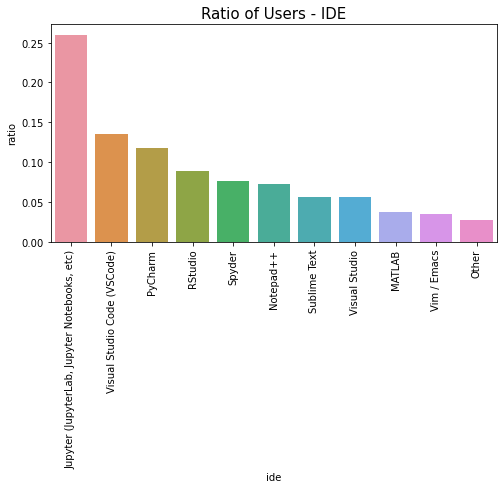

In [24]:
ide = pd.Series('|'.join(df['ide'].values).split('|')).value_counts(normalize=True).reset_index().rename(columns={'index':'ide', 0:'ratio'})
ide = ide.loc[lambda x: (x['ide'] != '') & (x['ide'] != 'None')]

plt.figure(figsize=(8, 4))
plt.title('Ratio of Users - IDE', fontsize=15)
ax = sns.barplot(data=ide, x='ide', y='ratio')
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
print('Top 3 IDEs: Jupyter | Visual Studio Code | PyCharm')

Top 3 notebook platforms: Colab | Kaggle | JupyterHub


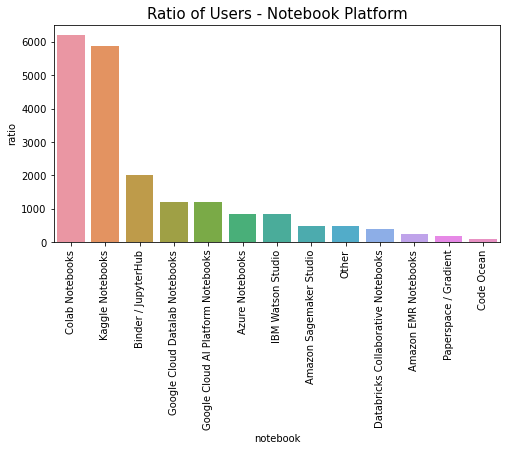

In [25]:
notebook = pd.Series('|'.join(df['notebook'].values).split('|')).value_counts().reset_index().rename(columns={'index':'notebook', 0:'ratio'})
notebook = notebook.loc[lambda x: (x['notebook'] != '') & (x['notebook'] != 'None')]

plt.figure(figsize=(8, 4))
plt.title('Ratio of Users - Notebook Platform', fontsize=15)
ax = sns.barplot(data=notebook, x='notebook', y='ratio')
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
print('Top 3 notebook platforms: Colab | Kaggle | JupyterHub')

In [26]:
notebook_by_job = df.groupby(['job_title']).apply(lambda x: pd.Series('|'.join(x['notebook'].values).split('|')).value_counts()/x['notebook'].shape[0]).reset_index()
notebook_by_job.rename(columns={'level_1':'notebook', 0:'ingroup_ratio'}, inplace=True)

notebook_by_codeexp = df.groupby(['code_exp']).apply(lambda x: pd.Series('|'.join(x['notebook'].values).split('|')).value_counts()/x['notebook'].shape[0]).reset_index()
notebook_by_codeexp.rename(columns={'level_1':'notebook', 0:'ingroup_ratio'}, inplace=True)
notebook_by_codeexp = get_code_exp_order(notebook_by_codeexp)
notebook_by_codeexp = notebook_by_codeexp.sort_values(by=['exp_order'])

Here, we see that Kaggle and Colab are Machine Learning Engineers favorite, while Data Scientists also like them.
Amazon Sagemaker doesn't have much ratio of users comparing with Kaggle and Google Colab, maybe it's because Kaggle is more connected with Google products.
* Although there aren't many users in the survey, what's interesting is there is a gap between the use preference for students and people who work as ds related jobs.
* Only small portion of the students use Amazon Sagemaker, but Data Scientists, Data Engineers, and Machine Learning Engineers are using them.


People with 1-5 years coding experience are most actively using Kaggle and Colab.
Great to see that those with 5-10 years are also active on the two platforms becuase they highly taking charge of who to hire in a typical DS team.


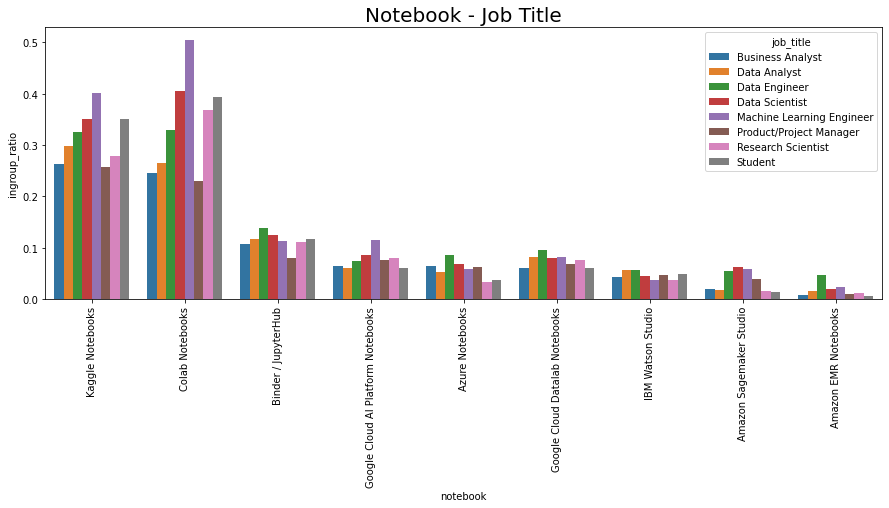

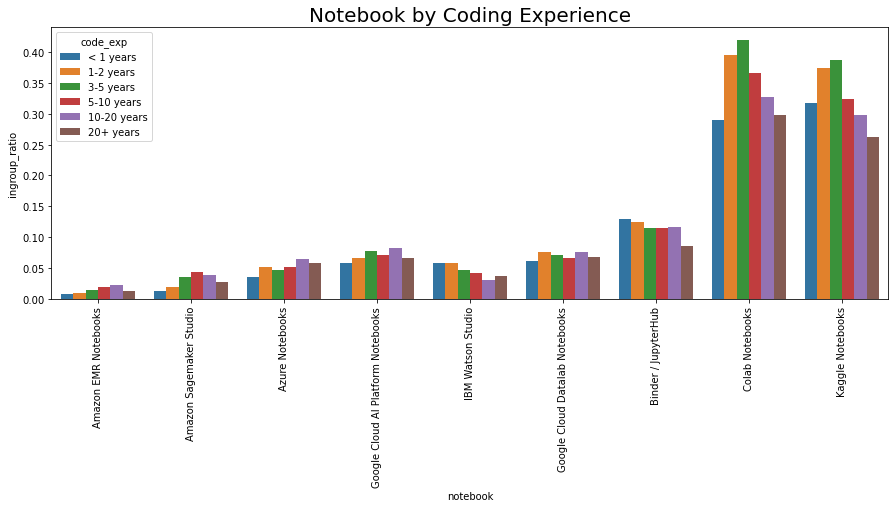

In [27]:
nb_to_consider = ['Kaggle Notebooks', 'Colab Notebooks', 'Binder / JupyterHub', 'Google Cloud AI Platform Notebooks', 'Azure Notebooks', 
                  'Google Cloud Datalab Notebooks', 'IBM Watson Studio', 'Amazon Sagemaker Studio', 'Amazon EMR Notebooks']
jt_to_consider = ['Student', 'Business Analyst', 'Data Analyst', 'Data Engineer', 'Data Scientist', 
                  'Machine Learning Engineer', 'Product/Project Manager', 'Research Scientist']

plt.figure(figsize=(15, 5))
ax = sns.barplot(data=notebook_by_job.loc[lambda x: 
                                          (x['notebook'].isin(nb_to_consider)) & 
                                          (x['job_title'].isin(jt_to_consider))], 
                 x='notebook', 
                 y='ingroup_ratio', 
                 hue='job_title')
ax.set_title('Notebook - Job Title', fontsize=20)
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
print('Here, we see that Kaggle and Colab are Machine Learning Engineers favorite, while Data Scientists also like them.')
print("Amazon Sagemaker doesn't have much ratio of users comparing with Kaggle and Google Colab, maybe it's because Kaggle is more connected with Google products.")
print("* Although there aren't many users in the survey, what's interesting is there is a gap between the use preference for students and people who work as ds related jobs.")
print("* Only small portion of the students use Amazon Sagemaker, but Data Scientists, Data Engineers, and Machine Learning Engineers are using them.")
print('\n')

plt.figure(figsize=(15, 5))
ax_1 = sns.barplot(data=notebook_by_codeexp.loc[lambda x: 
                                                (x['notebook'].isin(nb_to_consider))], 
                   x='notebook', 
                   y='ingroup_ratio', 
                   hue='code_exp')
ax_1.set_title('Notebook by Coding Experience', fontsize=20)
ax_1.set_xticklabels(labels=ax_1.get_xticklabels(), rotation=90)
print('People with 1-5 years coding experience are most actively using Kaggle and Colab.')
print('Great to see that those with 5-10 years are also active on the two platforms becuase they highly taking charge of who to hire in a typical DS team.')

### Visualization Packages & Tools

In [28]:
vis = df.copy()
vis['num_vis'] = vis['lib_visual'].apply(lambda x: len(x.split('|')))
vis = get_num_X(vis, 'lib_visual', 'num_vis', dropna=False)
print('{:.2%} are using at least two different visualization packages.'.format(vis.loc[vis['num_vis'] > 1].shape[0]/df.shape[0]))

59.23% are using at least two different visualization packages.


Top 4 visualization packages: Matplotlib | Seaborn | Plotly | ggplot
Some less familiar packages: Bokeh | Geoplotlib | D3 js | Leaflet/Folium | Altair


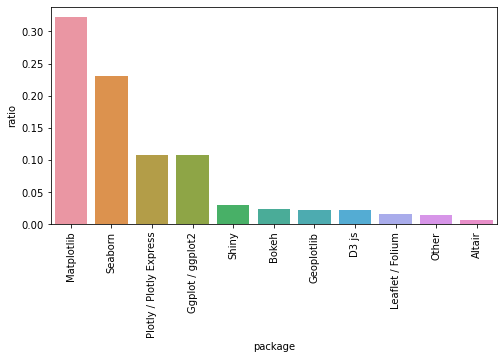

In [29]:
vis = pd.Series('|'.join(df['lib_visual'].values).split('|')).value_counts(dropna=False).reset_index() # however, we only consider people who filled out this part, so for the below plot we dropped '' and 'None' values 
vis.columns = ['package', 'frequency']
vis['ratio'] = vis['frequency']/vis['frequency'].sum()
vis.sort_values(by=['ratio'], ascending=False)

plt.figure(figsize=(8, 4))
ax = sns.barplot(data=vis.loc[~vis['package'].isin(['', 'None', None])], x='package', y='ratio') 
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
print('Top 4 visualization packages: Matplotlib | Seaborn | Plotly | ggplot')
print('Some less familiar packages: Bokeh | Geoplotlib | D3 js | Leaflet/Folium | Altair')

Machine learning engineers love Matplotlib most, maybe it is easier to be integrated as part of the analytical pipeline?
Data Scientist has no.1 usage on the following packages: Seaborn | Ggplot | Plotly | Shiny | Bokeh | Leaflet/Folium, and these packages have things in common: easthetical, easy-to-use, interactive
Especially for plotly, comparing with other jobs titles, data scientists have more than 10% of people using it.


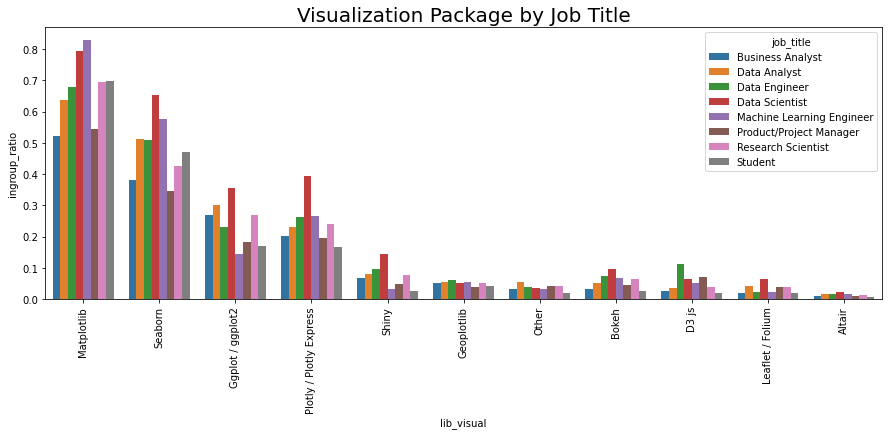

In [30]:
vis_by_job = df.groupby(['job_title']).apply(lambda x: pd.Series('|'.join(x['lib_visual'].values).split('|')).value_counts()/x['lib_visual'].shape[0]).reset_index()
vis_by_job.rename(columns={'level_1':'lib_visual', 0:'ingroup_ratio'}, inplace=True)

plt.figure(figsize=(15, 5))
ax = sns.barplot(data=vis_by_job.loc[lambda x: (x['job_title'].isin(jt_to_consider)) & 
                                               (~x['lib_visual'].isin(['', 'None', None]))], 
                 x='lib_visual', 
                 y='ingroup_ratio', 
                 hue='job_title')
ax.set_title('Visualization Package by Job Title', fontsize=20)
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90);
print('Machine learning engineers love Matplotlib most, maybe it is easier to be integrated as part of the analytical pipeline?')
print('Data Scientist has no.1 usage on the following packages: Seaborn | Ggplot | Plotly | Shiny | Bokeh | Leaflet/Folium, and these packages have things in common: easthetical, easy-to-use, interactive')
print('Especially for plotly, comparing with other jobs titles, data scientists have more than 10% of people using it.')

### Machine Learning Skills

In [31]:
def get_ml_exp_order(df):
    """Create machine learning experience ordinal column. new column name is 'num_ml_exp'"""
    df['num_ml_exp'] = df['ml_exp'].replace({'I do not use machine learning methods':0,
                                             'Under 1 year':0.5,
                                             '1-2 years':1.5,
                                             '2-3 years':2.5,
                                             '3-4 years':3.5,
                                             '4-5 years':4.5,
                                             '5-10 years':7.5,
                                             '10-20 years':15,
                                             '20 or more years':25})
    
    return df

Here, we can see the correlation between number of ml experience to number of ml frameworks and algorithms they reagularly use:


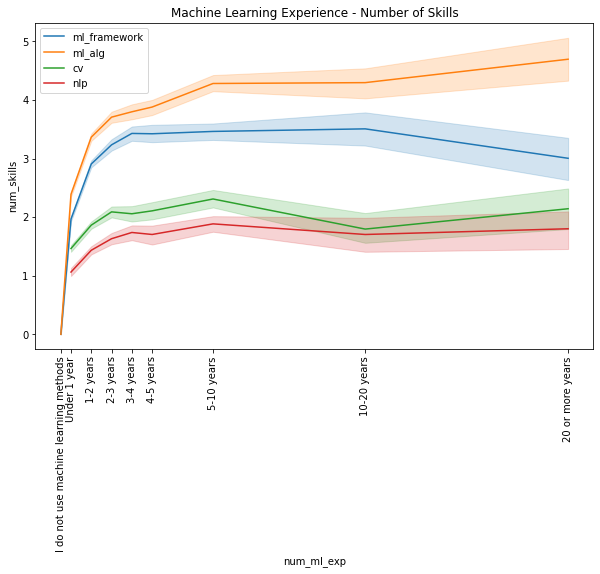

In [32]:
ml = df.copy().loc[lambda x: ~x['ml_exp'].isnull()] # here we only consider people who filled out this part (the condition)
ml = get_ml_exp_order(ml)

# get number of skills
ml = (ml.pipe(get_num_X, col='ml_framework', new_col='num_ml_framework')
        .pipe(get_num_X, col='ml_alg', new_col='num_ml_alg')
        .pipe(get_num_X, col='cv', new_col='num_cv')
        .pipe(get_num_X, col='nlp', new_col='num_nlp'))

# people only select None or nothing should have 0 number 
ml.loc[lambda x: (x['ml_framework'] == 'None') | (x['ml_alg'] == ''), 'num_ml_framework'] = 0
ml.loc[lambda x: (x['ml_alg'] == 'None') | (x['ml_alg'] == ''), 'num_ml_alg'] = 0
ml.loc[lambda x: (x['cv'] == 'None') | (x['cv'] == ''), 'num_cv'] = 0
ml.loc[lambda x: (x['nlp'] == 'None') | (x['nlp'] == ''), 'num_nlp'] = 0

plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=ml.sort_values(by=['num_ml_exp']), x='num_ml_exp', y='num_ml_framework', label='ml_framework')
ax = sns.lineplot(data=ml.sort_values(by=['num_ml_exp']), x='num_ml_exp', y='num_ml_alg', label='ml_alg')
ax = sns.lineplot(data=ml.loc[~ml['cv'].isin(['', None])].sort_values(by=['num_ml_exp']), x='num_ml_exp', y='num_cv', label='cv') #
ax = sns.lineplot(data=ml.loc[~ml['nlp'].isin(['', None])].sort_values(by=['num_ml_exp']), x='num_ml_exp', y='num_nlp', label='nlp')
plt.title('Machine Learning Experience - Number of Skills')
plt.ylabel('num_skills')
plt.xticks([0, 0.5, 1.5, 2.5, 3.5, 4.5, 7.5, 15, 25], ml.sort_values(by=['num_ml_exp'])['ml_exp'].unique().tolist(), rotation=90)
print('Here, we can see the correlation between number of ml experience to number of ml frameworks and algorithms they reagularly use:')

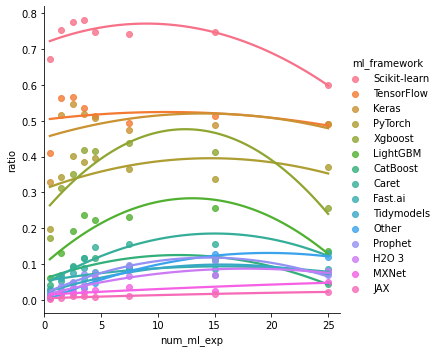

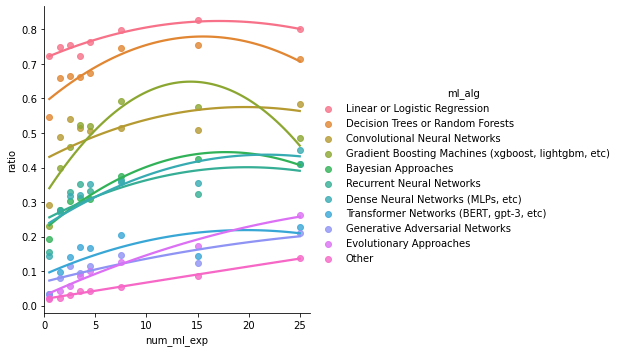

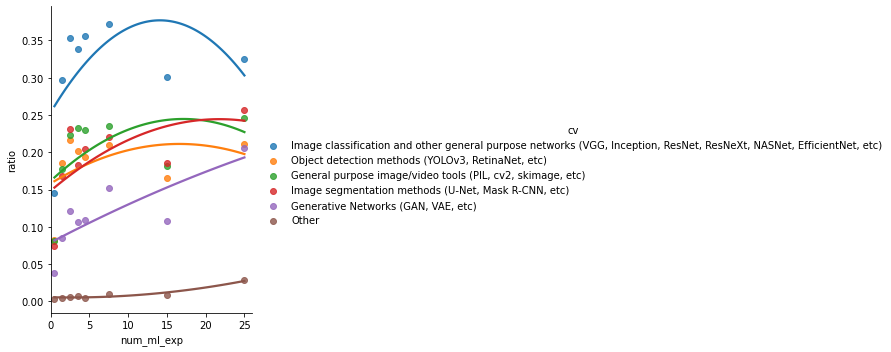

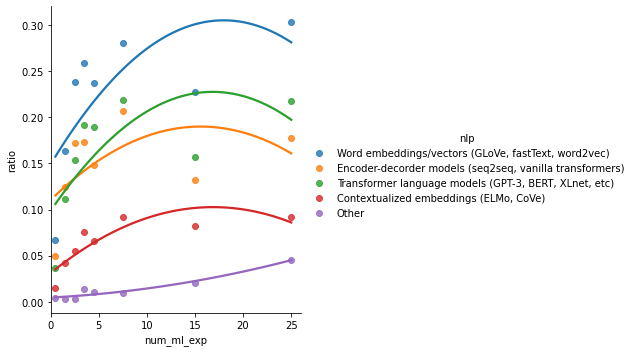

In [33]:
for col in ['ml_framework', 'ml_alg', 'cv', 'nlp']: 
    data = ml.groupby(['num_ml_exp', 'ml_exp']).apply(lambda x: get_ratio_of_people(x, col=col)).reset_index().loc[lambda x: ~x[col].isin(['', 'None'])]
    ax = sns.lmplot(data=data, x='num_ml_exp', y='ratio', hue=col, ci=None, order=2, truncate=True, size=5); 
    plt.xlim((0, 26))

### Let's check out some job responsibilities at work 💻📁📊📝. We can categorize them into the following three by universality 🌐:
* Top1: Analytics 📈📊. Common tasks are Exploratory Data Analysis, Data Mining, Data Manipulation, Data Cleaning, Data Processing, Creating Business Insights, and Visualization
* Top2: Machine Learning R&D 🔩⚙️. Common tasks are exploring ML applications, building up ML frameworks and POCs, and algorithms optimization
* Top3: Pipeline/Archetecture 🚰🕸️. Common tasks are building up Data Infrastructure and Pipeline using Platforms like AWS, GCP

The most common job responsibility for ds-related jobs is analyze and understand data to drive thinking.
The 2nd common job responsibility is accomplish Proof of Concepts in new aras by applying machine learning.
The 3rd common job responsibility is build and run data manipulation infrastructure/pipeline.


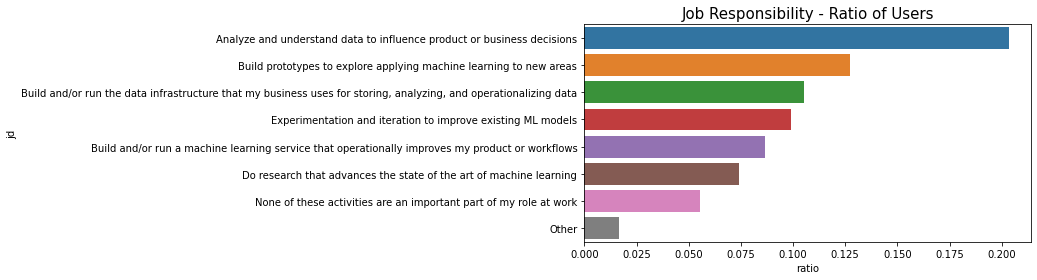

In [34]:
jd = pd.Series('|'.join(df['jd']).split('|')).value_counts(normalize=True).reset_index().rename(columns={'index':'jd', 0:'ratio'})
plt.figure(figsize=(8, 4))
sns.barplot(data=jd.loc[~jd['jd'].isin(['', 'None', None])], y='jd', x='ratio')
plt.title('Job Responsibility - Ratio of Users', fontsize=15)
print('The most common job responsibility for ds-related jobs is analyze and understand data to drive thinking.')
print('The 2nd common job responsibility is accomplish Proof of Concepts in new aras by applying machine learning.')
print('The 3rd common job responsibility is build and run data manipulation infrastructure/pipeline.')

### Let's see what the following table tell us 🙊:
* For most data-related jobs, they have specific one job responsibility which is clearly more important than the rest. 
* However, data scientists, machine learning engineers, and research scientists don't have one which is apparently more important than the others, rather, they are taking multiple job responsibilities at the same time 💪🏼💪🏼💪🏼. Well, they are better expected to be the 🦸 knowing how to 🏋 projects end2end!

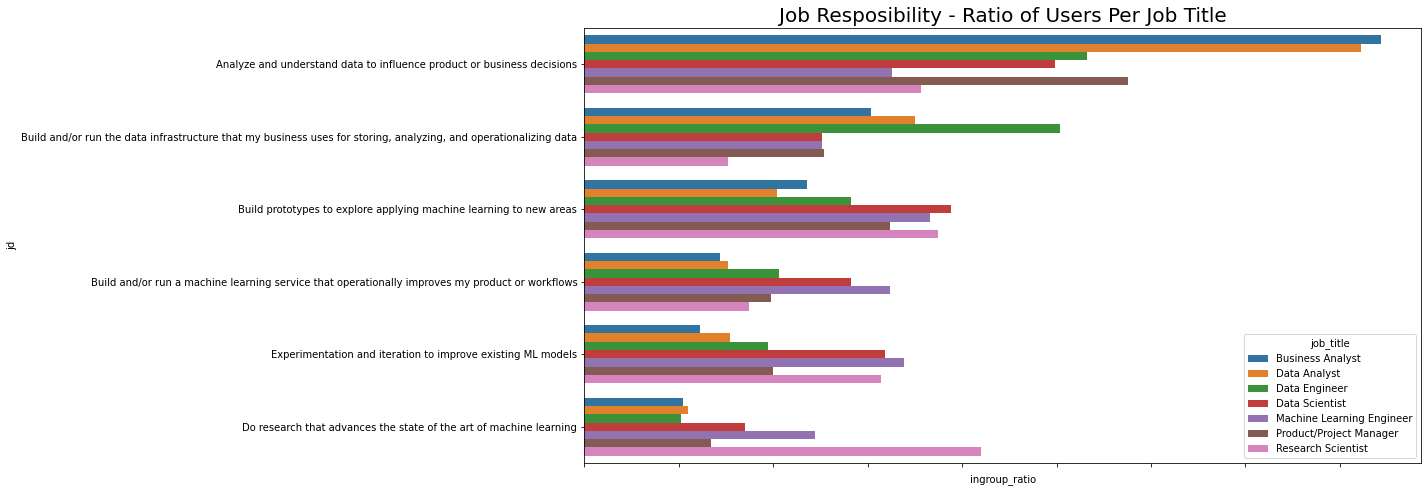

In [35]:
jd_by_jt = df.groupby(['job_title']).apply(lambda x: pd.Series('|'.join(x['jd']).split('|')).value_counts().reset_index())
jd_by_jt = jd_by_jt.reset_index().rename(columns={'index':'jd', 0:'freq'}).drop(columns=['level_1'])
jd_by_jt = jd_by_jt.merge(jd_by_jt.groupby(['job_title'])['freq'].sum().reset_index().rename(columns={'freq':'total'}), on=['job_title'])
jd_by_jt['ingroup_ratio'] = np.round(jd_by_jt['freq']/jd_by_jt['total'], 3)

plt.figure(figsize=(15, 8))
ax = sns.barplot(data=jd_by_jt.loc[lambda x: 
                                          (x['job_title'].isin(jt_to_consider)) & 
                                          (x['jd'] != '') &
                                          (~x['jd'].isin(['None of these activities are an important part of my role at work', 'Other']))], 
                 y='jd', 
                 x='ingroup_ratio', 
                 hue='job_title', 
                 orient='h')
ax.set_title('Job Resposibility - Ratio of Users Per Job Title', fontsize=20)
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90);

### User's Costs 💵 on ML & Cloud Services
* Data scientists 👩‍🔬👨‍🔬 stand out to be the group who have the strongest willingness to put money on ML & Cloud services: more than 25% of people spent 1-999💰, and another similar amount of people spent 10000+💰 in the last 5 years. I would doubt why they spent so much as data scientist maybe they are providing end-to-end service? Or they are building something huge by themselves for themselves? Or they just ... rich? 🤔🤔🤔 (p.s. just a gentle reminder here never forget to stop all the instances whenever you finish using the services, otherwise your money will blow away 💸💸💸)
* The cost on machine learning and cloud services is positively correlated to the company size, the data science team size, and the company's stage of machine learning developements.
* Data engineers, machine learning engineers, and project/product managers are also willing to spend money but a large group of them just make some small plays like spending 1-999💰 in the last 5 years. 
* In general, I would rank the spending power like this: data scientists > data engineers > machine learning engineers = project/product managers > research scientists > data analysts > business analysts

In [36]:
def get_ml_cost_cat(df):
    """Create the categorical column for machine learning cost in the previous 5 years. new column name is 'cost_cat'"""
    df.loc[df['ml_cost_prev_5_year'] == '$0 ($USD)', 'cost_cat'] = 'no cost ($0)'
    df.loc[df['ml_cost_prev_5_year'].isin(['$1-$99', '$100-$999']), 'cost_cat'] = 'small cost ($1-999)'
    df.loc[df['ml_cost_prev_5_year'] == '$1000-$9,999', 'cost_cat'] = 'medium cost ($1000-9999)'
    df.loc[df['ml_cost_prev_5_year'].isin(['$10,000-$99,999', '$100,000 or more ($USD)']), 'cost_cat'] = 'large cost ($10000+)'
    
    return df

def get_emp_size_cat(df):
    """Create the categorical column for employer size. new column name is 'employer_size_cat'"""
    df.loc[lambda x: x['employer_size'].isin(['0-49 employees', '50-249 employees']), 'employer_size_cat'] = 'small'
    df.loc[lambda x: x['employer_size'].isin(['250-999 employees']), 'employer_size_cat'] = 'medium'
    df.loc[lambda x: x['employer_size'].isin(['1000-9,999 employees', '10,000 or more employees']), 'employer_size_cat'] = 'large'

    return df

def get_bus_ds_size_cat(df):
    """Create the categorical column for the business data science team size. new column name is 'bus_ds_size_cat'"""
    df.loc[lambda x: x['bus_ds_size'].isin(['0', np.nan]), 'bus_ds_size_cat'] = 'no'
    df.loc[lambda x: x['bus_ds_size'].isin(['1-2', '3-4', '5-9']), 'bus_ds_size_cat'] = 'small'
    df.loc[lambda x: x['bus_ds_size'].isin(['10-14']), 'bus_ds_size_cat'] = 'medium'
    df.loc[lambda x: x['bus_ds_size'].isin(['15-19', '20+']), 'bus_ds_size_cat'] = 'large'
    
    return df

def get_emp_ml_stage_cat(df):
    """Create the categorical column for employer's machine learning stage. new column name is 'employer_ml_stage_cat'"""
    df.loc[lambda x: x['employer_ml_stage'].isin([np.nan, 'No (we do not use ML methods)']), 'employer_ml_stage_cat'] = 'no'
    df.loc[lambda x: x['employer_ml_stage'].isin(['We use ML methods for generating insights (but do not put working models into production)']), 'employer_ml_stage_cat'] = 'init'
    df.loc[lambda x: x['employer_ml_stage'].isin(['We are exploring ML methods (and may one day put a model into production)', 'We recently started using ML methods (i.e., models in production for less than 2 years)']), 'employer_ml_stage_cat'] = 'grow'
    df.loc[lambda x: x['employer_ml_stage'].isin(['We have well established ML methods (i.e., models in production for more than 2 years)']), 'employer_ml_stage_cat'] = 'devoped'
    
    return df

def get_ml_cost_order(df):
    """Create the ordinal column machine learning cost in the previous 5 years. new column name is 'ml_cost_order'"""
    if 'ml_cost_prev_5_year' in df.columns:
        df.loc[df['ml_cost_prev_5_year'] == '$0 ($USD)', 'ml_cost_order'] = 0
        df.loc[df['ml_cost_prev_5_year'].isin(['$1-$99', '$100-$999']), 'ml_cost_order'] = 999
        df.loc[df['ml_cost_prev_5_year'] == '$1000-$9,999', 'ml_cost_order'] = 9999
        df.loc[df['ml_cost_prev_5_year'].isin(['$10,000-$99,999', '$100,000 or more ($USD)']), 'ml_cost_order'] = 20000
    else:
        df.loc[df['cost_cat'] == 'no cost ($0)', 'ml_cost_order'] = 0
        df.loc[df['cost_cat'] == 'small cost ($1-999)', 'ml_cost_order'] = 999
        df.loc[df['cost_cat'] == 'medium cost ($1000-9999)', 'ml_cost_order'] = 9999
        df.loc[df['cost_cat'] == 'large cost ($10000+)', 'ml_cost_order'] = 20000     
    
    return df

def get_emp_size_order(df):
    """Create employer size ordinal column. new column name is 'emp_size_order'"""
    if 'employer_size' in df.columns:
        df.loc[lambda x: x['employer_size'].isin(['0-49 employees', '50-249 employees']), 'emp_size_order'] = 1
        df.loc[lambda x: x['employer_size'].isin(['250-999 employees']), 'emp_size_order'] = 2
        df.loc[lambda x: x['employer_size'].isin(['1000-9,999 employees', '10,000 or more employees']), 'emp_size_order'] = 3
    else:
        df.loc[lambda x: x['employer_size_cat'] == 'small', 'emp_size_order'] = 1
        df.loc[lambda x: x['employer_size_cat'] == 'medium', 'emp_size_order'] = 2
        df.loc[lambda x: x['employer_size_cat'] == 'large', 'emp_size_order'] = 3
    
    return df

def get_bus_ds_size_order(df):
    """Create ordinal column for business data science size. new column name is 'bus_ds_size_order'"""
    if 'bus_ds_size' in df.columns:
        df.loc[lambda x: x['bus_ds_size'].isin(['0', np.NaN, '', 'None', None]), 'bus_ds_size_order'] = 0
        df.loc[lambda x: x['bus_ds_size'].isin(['1-2', '3-4', '5-9']), 'bus_ds_size_order'] = 1
        df.loc[lambda x: x['bus_ds_size'].isin(['10-14']), 'bus_ds_size_order'] = 2
        df.loc[lambda x: x['bus_ds_size'].isin(['15-19', '20+']), 'bus_ds_size_order'] = 3
    else:
        df.loc[lambda x: x['bus_ds_size_cat'] == 'no', 'bus_ds_size_order'] = 0
        df.loc[lambda x: x['bus_ds_size_cat'] == 'small', 'bus_ds_size_order'] = 1
        df.loc[lambda x: x['bus_ds_size_cat'] == 'medium', 'bus_ds_size_order'] = 2
        df.loc[lambda x: x['bus_ds_size_cat'] == 'large', 'bus_ds_size_order'] = 3    
    
    return df

def get_emp_ml_stage_order(df):
    """Create ordinal column for employer machine learning stage. new column name is 'employer_ml_stage_order'"""
    if 'employer_ml_stage' in df.columns:
        df.loc[lambda x: x['employer_ml_stage'].isin([np.nan, 'No (we do not use ML methods)']), 'employer_ml_stage_order'] = 0
        df.loc[lambda x: x['employer_ml_stage'].isin(['We use ML methods for generating insights (but do not put working models into production)']), 'employer_ml_stage_order'] = 1
        df.loc[lambda x: x['employer_ml_stage'].isin(['We are exploring ML methods (and may one day put a model into production)', 'We recently started using ML methods (i.e., models in production for less than 2 years)']), 'employer_ml_stage_order'] = 2
        df.loc[lambda x: x['employer_ml_stage'].isin(['We have well established ML methods (i.e., models in production for more than 2 years)']), 'employer_ml_stage_order'] = 3
    else:
        df.loc[lambda x: x['employer_ml_stage_cat'] == 'no', 'employer_ml_stage_order'] = 0
        df.loc[lambda x: x['employer_ml_stage_cat'] == 'init', 'employer_ml_stage_order'] = 1
        df.loc[lambda x: x['employer_ml_stage_cat'] == 'grow', 'employer_ml_stage_order'] = 2
        df.loc[lambda x: x['employer_ml_stage_cat'] == 'devoped', 'employer_ml_stage_order'] = 3 
        
    return df
    

In [37]:
cloud = df.copy().loc[lambda x: x['job_title'].isin(jt_to_consider)] # only data related jobs are our interest
cloud['jt_cat'] = cloud['job_title'].apply(lambda x: 'student' if x == 'Student' else 'experienced')

# get the categorical columns
cloud = (cloud.pipe(get_ml_cost_cat)
              .pipe(get_emp_size_cat)
              .pipe(get_bus_ds_size_cat)
              .pipe(get_emp_ml_stage_cat))

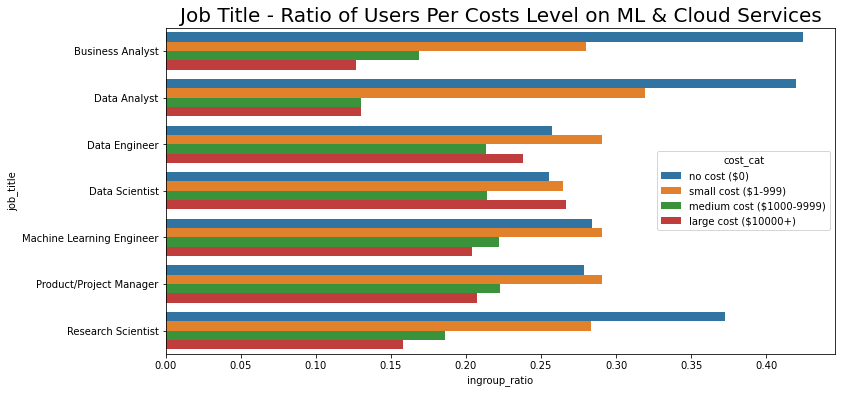

In [38]:
cost_by_jt = cloud.groupby(['job_title']).apply(lambda x: x['cost_cat'].value_counts(normalize=True)).reset_index().rename(columns={'level_1':'cost_cat', 'cost_cat':'ingroup_ratio'})

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=cost_by_jt, y='job_title', x='ingroup_ratio', hue='cost_cat', orient='h')
ax.set_title("Job Title - Ratio of Users Per Costs Level on ML & Cloud Services", fontsize=20);

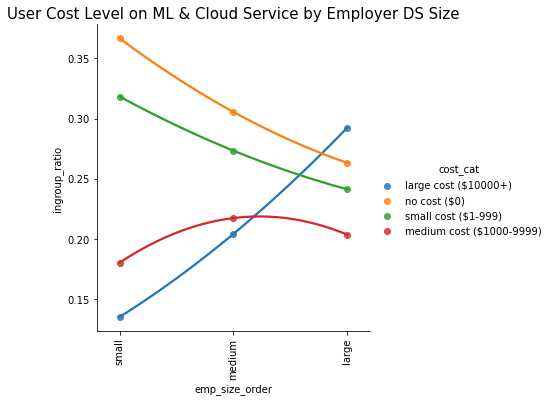

In [39]:
col = 'employer_size_cat'
cost_by_size = cloud.groupby([col]).apply(lambda x: x['cost_cat'].value_counts(normalize=True)).reset_index().rename(columns={'level_1':'cost_cat', 'cost_cat':'ingroup_ratio'})
cost_by_size = get_emp_size_order(cost_by_size)

sns.lmplot(data=cost_by_size, x='emp_size_order', y='ingroup_ratio', hue='cost_cat', ci=None, order=2, truncate=True, size=5); 
plt.title('User Cost Level on ML & Cloud Service by Employer DS Size', fontsize=15)
ax.set_title('User Cost Level on ML & Cloud Service by Employer DS Size')
plt.xticks(np.arange(1, 4), ['small', 'medium', 'large'], rotation=90)
plt.xlim((0.8, 3.2));

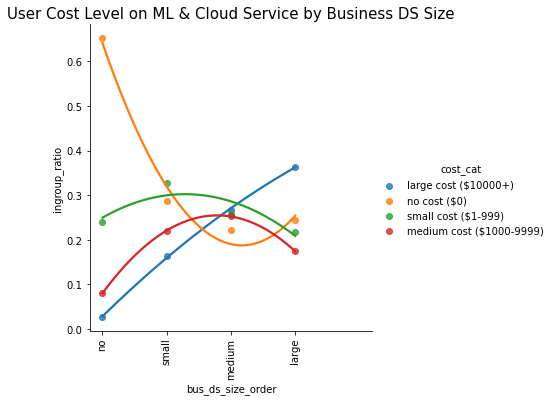

In [40]:
col = 'bus_ds_size_cat'
cost_by_size = cloud.groupby([col]).apply(lambda x: x['cost_cat'].value_counts(normalize=True)).reset_index().rename(columns={'level_1':'cost_cat', 'cost_cat':'ingroup_ratio'})
cost_by_size = get_bus_ds_size_order(cost_by_size)

sns.lmplot(data=cost_by_size, x='bus_ds_size_order', y='ingroup_ratio', hue='cost_cat', ci=None, order=2, truncate=True, size=5); 
plt.title('User Cost Level on ML & Cloud Service by Business DS Size', fontsize=15)
plt.xticks(np.arange(4), ['no', 'small', 'medium', 'large'], rotation=90)
plt.xlim((-0.2, 4.2));

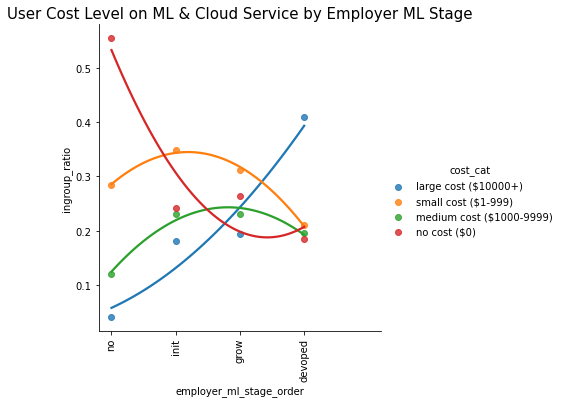

In [41]:
col = 'employer_ml_stage_cat'
cost_by_stage = cloud.groupby([col]).apply(lambda x: x['cost_cat'].value_counts(normalize=True)).reset_index().rename(columns={'level_1':'cost_cat', 'cost_cat':'ingroup_ratio'})
cost_by_stage = get_emp_ml_stage_order(cost_by_stage)

sns.lmplot(data=cost_by_stage, x='employer_ml_stage_order', y='ingroup_ratio', hue='cost_cat', ci=None, order=2, truncate=True, size=5); 
plt.title('User Cost Level on ML & Cloud Service by Employer ML Stage', fontsize=15)
plt.xticks(np.arange(4), ['no', 'init', 'grow', 'devoped'], rotation=90)
plt.xlim((-0.2, 4.2));

### Sharing work and projects to the public is really good for the community because it not only helps others understand and learn your ideas but you to get feedbacks from people in various of backgrounds. Kagglers are doing it on Kaggle 🥇! And when we dig a little more, we found:
* In general, Machine learning engineers, data scientists, and data engineers have higher willingness to share work on platforms 😊😊😊
* Students and the unemployeed don't share work to any platform at all
* More than 50% of Kagglers don't share their work
* Top1 share platform is Github

In [42]:
share = df.copy()
share.loc[share['share_plfm'].isin(['', 'I do not share my work publicly']), 'num_share_plfm'] = 0
share.loc[~share['share_plfm'].isin(['', 'I do not share my work publicly']), 'num_share_plfm'] = share.loc[~share['share_plfm'].isin(['', 'I do not share my work publicly']), 'share_plfm'].apply(lambda x: len(x.split('|')))
print('Machine Learning Engineers, Data Scientists, and Data Engineers have larger ratio of people who share their work on public platforms.')
print('{}({:.2%}) of Machine Learning Engineers, {}({:.2%}) of Data Scientists, and {}({:.2%}) of Data Engineers.'.format(share.loc[(share['job_title'] == 'Machine Learning Engineer') & (share['num_share_plfm'] >= 1)].shape[0],
                                                                                                            share.loc[(share['job_title'] == 'Machine Learning Engineer') & (share['num_share_plfm'] >= 1)].shape[0]/share.loc[(share['job_title'] == 'Machine Learning Engineer')].shape[0],
                                                                                                            share.loc[(share['job_title'] == 'Data Scientist') & (share['num_share_plfm'] >= 1)].shape[0], 
                                                                                                            share.loc[(share['job_title'] == 'Data Scientist') & (share['num_share_plfm'] >= 1)].shape[0]/share.loc[(share['job_title'] == 'Data Scientist')].shape[0],
                                                                                                            share.loc[(share['job_title'] == 'Data Engineer') & (share['num_share_plfm'] >= 1)].shape[0],
                                                                                                            share.loc[(share['job_title'] == 'Data Engineer') & (share['num_share_plfm'] >= 1)].shape[0]/share.loc[(share['job_title'] == 'Data Engineer')].shape[0]))
share.loc[lambda x: x['job_title'].isin(jt_to_consider)].groupby(['job_title'])['num_share_plfm'].describe(percentiles=[0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.995])

Machine Learning Engineers, Data Scientists, and Data Engineers have larger ratio of people who share their work on public platforms.
453(43.60%) of Machine Learning Engineers, 1191(45.98%) of Data Scientists, and 171(40.81%) of Data Engineers.


,count,mean,std,min,50%,60%,70%,80%,90%,95%,99%,99.5%,max
job_title,,,,,,,,,,,,,
Business Analyst,751.0,0.439414,0.846163,0.0,0.0,0.0,0.0,1.0,2.0,2.0,3.00,3.250,4.0
Data Analyst,1392.0,0.616379,1.047796,0.0,0.0,0.0,1.0,1.0,2.0,3.0,4.00,4.045,8.0
Data Engineer,419.0,0.809069,1.196811,0.0,0.0,1.0,1.0,2.0,3.0,3.0,4.82,5.000,5.0
Data Scientist,2590.0,0.933591,1.245242,0.0,0.0,1.0,1.0,2.0,3.0,3.0,5.00,5.000,8.0
Machine Learning Engineer,1039.0,0.899904,1.235938,0.0,0.0,1.0,1.0,2.0,3.0,3.0,5.00,5.000,8.0
Product/Project Manager,650.0,0.618462,0.983201,0.0,0.0,0.0,1.0,1.0,2.0,3.0,4.00,4.000,5.0
Research Scientist,1141.0,0.711656,1.093094,0.0,0.0,0.0,1.0,2.0,2.0,3.0,4.00,5.000,6.0
Student,4575.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0


More than 50% of people don't share their work to public platforms.


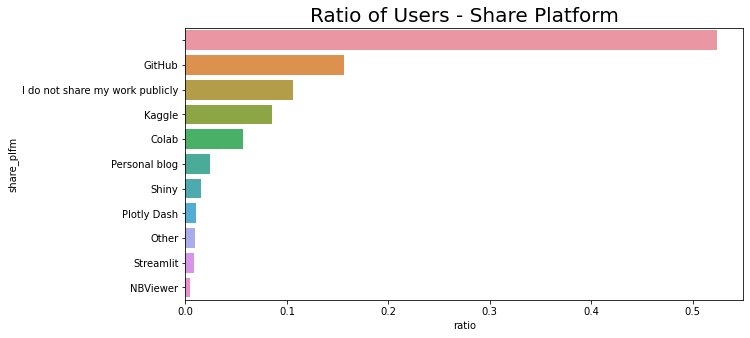

In [43]:
share_plfm = pd.Series('|'.join(df['share_plfm'].values).split('|')).value_counts(normalize=True).reset_index().rename(columns={'index':'share_plfm', 0:'ratio'})
plt.figure(figsize=(10, 5))
sns.barplot(data=share_plfm, x='ratio', y='share_plfm')
plt.title('Ratio of Users - Share Platform', fontsize=20)
print("More than 50% of people don't share their work to public platforms.")

Students and people currently not employed doesn't share their work to platforms.
Data Scientists is the most active group sharing work.


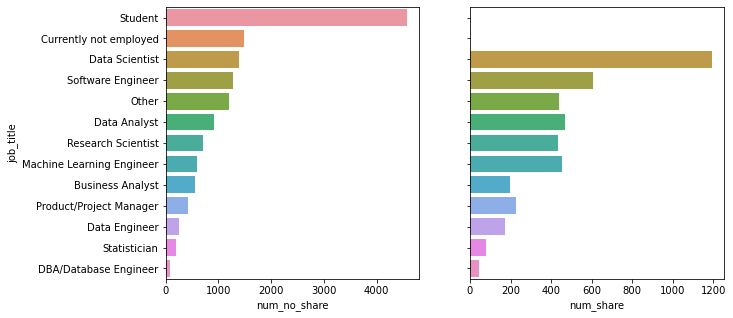

In [44]:
share_by_jt = share.loc[lambda x: x['num_share_plfm'] < 1]['job_title'].value_counts().reset_index().rename(columns={'index':'job_title', 'job_title':'num_no_share'})
share_by_jt = share_by_jt.merge(share.loc[lambda x: x['num_share_plfm'] >= 1]['job_title'].value_counts().reset_index().rename(columns={'index':'job_title', 'job_title':'num_share'}),
                                on='job_title', 
                                how='outer').fillna(0)
                             
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))
sns.barplot(data=share_by_jt, x='num_no_share', y='job_title', ax=ax1)
sns.barplot(data=share_by_jt, x='num_share', y='job_title', ax=ax2)
ax2.set_ylabel('')
print("Students and people currently not employed doesn't share their work to platforms.")
print("Data Scientists is the most active group sharing work.")

### Course Platforms
* More than 18% of Kagglers like Coursera the most, followed by Kaggle Learn Courses (12.5%) and Udemy (12%)
* Around 19% of students don't have online course platform to learn 
* Cloud-certification programs and Fast.ai have the least popularity having only 2.5% of Kagglers using them 😿😿😿

most people use Coursera to learn.


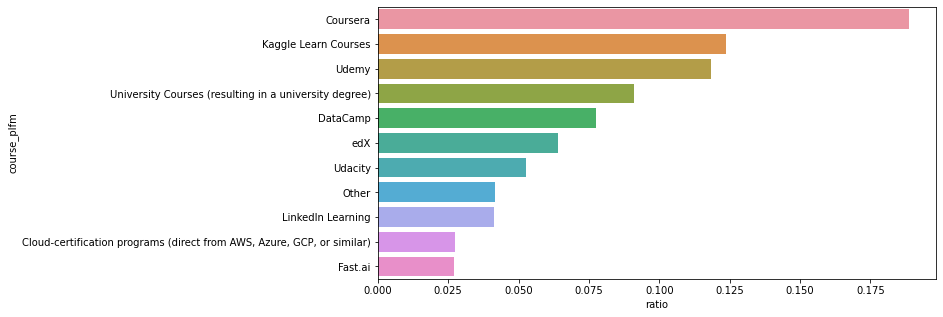

In [45]:
course = pd.Series('|'.join(df['ds_course_plfm'].values).split('|')).value_counts(normalize=True).reset_index().rename(columns={'index':'course_plfm', 0:'ratio'}).loc[lambda x: ~x['course_plfm'].isin(['', 'None'])]

plt.figure(figsize=(10, 5))
sns.barplot(data=course, x='ratio', y='course_plfm', orient='h')
print('most people use Coursera to learn.')

Experienced people tend to be more active on taking courses on most platforms, except Kaggle Learn Courses and University Courses.
A larger ratio of students left it blank. Maybe they don't take courses or they aren't confident enough to say they take courses.


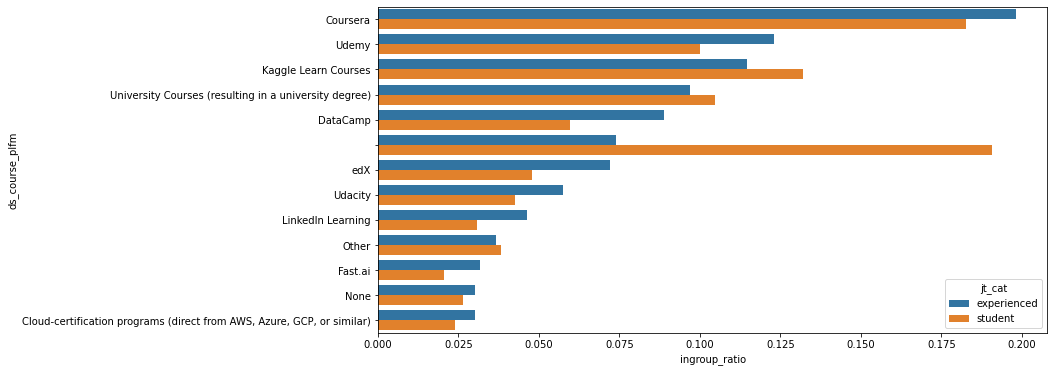

In [46]:
course_by_jt = df.copy().loc[lambda x: x['job_title'].isin(jt_to_consider)]
course_by_jt['jt_cat'] = course_by_jt['job_title'].apply(lambda x: 'student' if x == 'Student' else 'experienced')
course_by_jt = course_by_jt.groupby(['jt_cat']).apply(lambda x: pd.Series('|'.join(x['ds_course_plfm']).split('|')).value_counts(dropna=True, normalize=True)).reset_index().rename(columns={'level_1':'ds_course_plfm', 0:'ingroup_ratio'})

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=course_by_jt, y='ds_course_plfm', x='ingroup_ratio', hue='jt_cat', orient='h')
print('Experienced people tend to be more active on taking courses on most platforms, except Kaggle Learn Courses and University Courses.')
print("A larger ratio of students left it blank. Maybe they don't take courses or they aren't confident enough to say they take courses.")

### Data Science Media Sources
* Kaggle takes the 1st place 😬. But here, it shows that *Kaggle notebooks* and *Kaggle forums* are the two major ways, which are both in the readable and interactive formats
* Youtube takes the 2nd place. What are the popular channels to follow then?
* Blogs took the 3rd place. Popular accounts are *Towards Data Science* (everybody knows it 🤣) and *Analytics Vidhya*, and they are both in the readable format
* What students like more: *Youtube*
* What the experienced like more: *Kaggle*, *Blogs*, *Twitter*, *Journal Publications*, *Email Newsletters*, *Slack Communities*, *Podcasts*
* What students and the experienced have the similar like: *Reddit*, *Course Forums*

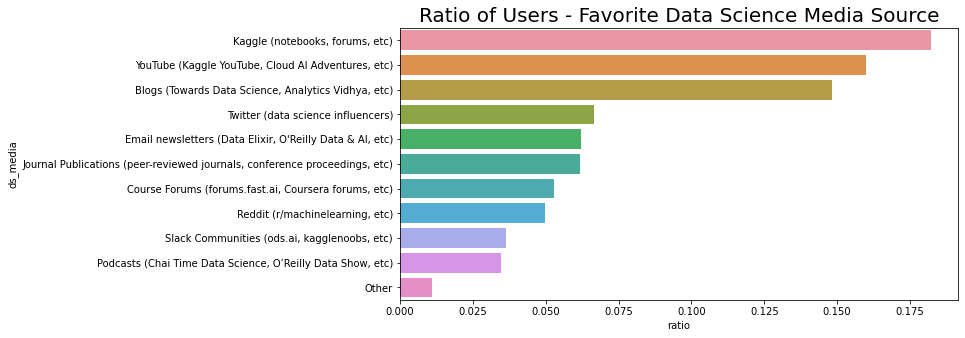

In [47]:
media = pd.Series('|'.join(df['ds_media'].values).split('|')).value_counts(normalize=True).reset_index().rename(columns={'index':'ds_media', 0:'ratio'}).loc[lambda x: ~x['ds_media'].isin(['', 'None'])]

plt.figure(figsize=(10, 5))
plt.title('Ratio of Users - Favorite Data Science Media Source', fontsize=20)
sns.barplot(data=media, x='ratio', y='ds_media', orient='h');

Experienced people tend to be more active on taking courses on most medias, except Youtube and course forums.
A larger ratio of students left it blank. Maybe they don't watch ds medias or they sometimes just randomly browsing different channels without realizing whatever they are using.


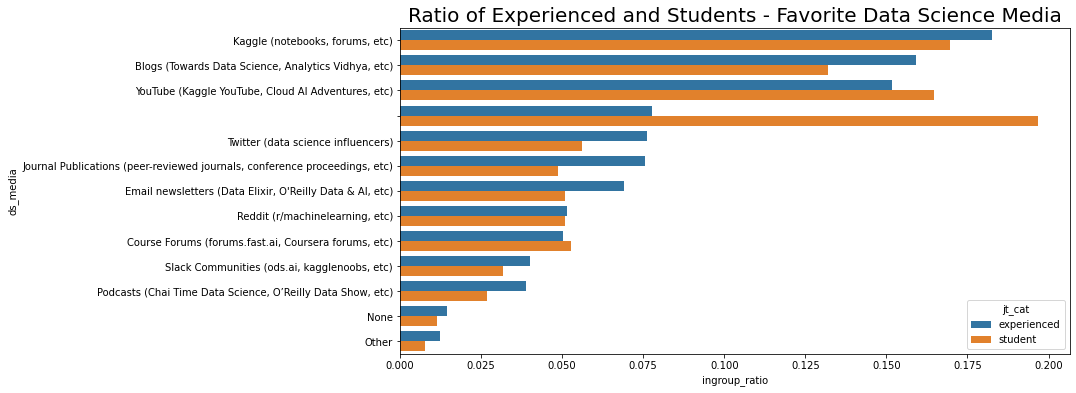

In [48]:
media_srce_by_jt = df.copy().loc[lambda x: x['job_title'].isin(jt_to_consider)] # only data related jobs are our interest
media_srce_by_jt['jt_cat'] = media_srce_by_jt['job_title'].apply(lambda x: 'student' if x == 'Student' else 'experienced')
media_srce_by_jt = media_srce_by_jt.groupby(['jt_cat']).apply(lambda x: pd.Series('|'.join(x['ds_media']).split('|')).value_counts(dropna=True, normalize=True)).reset_index().rename(columns={'level_1':'ds_media', 0:'ingroup_ratio'})

plt.figure(figsize=(12, 6))
plt.title('Ratio of Experienced and Students - Favorite Data Science Media', fontsize=20)
ax = sns.barplot(data=media_srce_by_jt, y='ds_media', x='ingroup_ratio', hue='jt_cat')
print('Experienced people tend to be more active on taking courses on most medias, except Youtube and course forums.')
print("A larger ratio of students left it blank. Maybe they don't watch ds medias or they sometimes just randomly browsing different channels without realizing whatever they are using.")

## Data Preparation

In [49]:
df = k_2020_adj.copy()

### Feature Selection

In [50]:
col_list = ['age', 'formal_edu', 'country', 'job_title', 'code_exp', 'language', 'ide', 'notebook', 
            'lib_visual', 'ml_exp', 'ml_framework', 'ml_alg', 'cv', 'nlp', 'jd', 'ml_cost_prev_5_year', 
            'employer_size', 'bus_ds_size', 'employer_ml_stage', 'share_plfm', 'ds_course_plfm', 'ds_media',
            'annual_comp']
df = df[col_list]

### Target

In [51]:
def get_annual_comp_cat(df):
    """Create the categorical column for annual compensation. the new column name is 'comp_cat'"""
    df.loc[df['annual_comp'].isin(['$0-999', '1,000-1,999', '2,000-2,999', '3,000-3,999', '4,000-4,999',
                                '5,000-7,499', '7,500-9,999', '10,000-14,999', '15,000-19,999', 
                                '20,000-24,999', '25,000-29,999', '30,000-39,999', '40,000-49,999',
                                '50,000-59,999', '60,000-69,999', '70,000-79,999', '80,000-89,999',
                                '90,000-99,999']), 'comp_cat'] = '<$100000'
    df.loc[df['annual_comp'].isin(['100,000-124,999', '125,000-149,999', '150,000-199,999']), 'comp_cat'] = '$100000-200000'
    df.loc[df['annual_comp'].isin(['200,000-249,999', '250,000-299,999', '300,000-500,000']), 'comp_cat'] = '$200000-500000'
    df.loc[df['annual_comp'].isin(['> $500,000']), 'comp_cat'] = '>$500000'
    
    return df

def get_annual_comp_order(df, is_simple=False):
    """Create the ordinal column for annual compensation. the new column name is 'comp_order'"""
    if is_simple:
        if 'annual_comp' in df.columns:
            df.loc[df['annual_comp'].isin(['$0-999', '1,000-1,999', '2,000-2,999', '3,000-3,999', '4,000-4,999',
                                        '5,000-7,499', '7,500-9,999', '10,000-14,999', '15,000-19,999', 
                                        '20,000-24,999', '25,000-29,999', '30,000-39,999', '40,000-49,999',
                                        '50,000-59,999', '60,000-69,999', '70,000-79,999', '80,000-89,999',
                                        '90,000-99,999']), 'comp_order'] = 100000
            df.loc[df['annual_comp'].isin(['100,000-124,999', '125,000-149,999', '150,000-199,999']), 'comp_order'] = 200000
            df.loc[df['annual_comp'].isin(['200,000-249,999', '250,000-299,999', '300,000-500,000']), 'comp_order'] = 500000
            df.loc[df['annual_comp'].isin(['> $500,000']), 'comp_order'] = 1000000
        else:
            df.loc[df['comp_cat'] == '<$100000', 'comp_order'] = 100000
            df.loc[df['comp_cat'] == '$100000-200000', 'comp_order'] = 200000
            df.loc[df['comp_cat'] == '$200000-500000', 'comp_order'] = 500000
            df.loc[df['comp_cat'] == '>$500000', 'comp_order'] = 1000000
    else:
        df['comp_order'] = df['annual_comp'].replace({'$0-999':999, '1,000-1,999':1999, '2,000-2,999':2999, '3,000-3,999':3999, 
                                                      '4,000-4,999':4999, '5,000-7,499':7499, '7,500-9,999':9999, '10,000-14,999':14999, 
                                                      '15,000-19,999':19999, '20,000-24,999':24999, '25,000-29,999':29999, '30,000-39,999':39999, 
                                                      '40,000-49,999':49999, '50,000-59,999':59999, '60,000-69,999':69999, '70,000-79,999':79999, '80,000-89,999':89999,
                                                      '90,000-99,999':99999, '100,000-124,999':124999, '125,000-149,999':149999, '150,000-199,999':199999,
                                                      '200,000-249,999':249999, '250,000-299,999':299999, '300,000-500,000':500000, '> $500,000':1000000})
    
    return df

In [52]:
# annual compensation is the target variable
df = (df
      #.pipe(get_annual_comp_cat)
      .pipe(get_annual_comp_order))

# we drop all the records which don't have annual compensation 
df = df.loc[~df['annual_comp'].isnull()]

### Missing values

In [53]:
for col in col_list:
    print('###################')
    print('column name:', col)
    print('number of missing values =', df[col].isnull().sum())
    print('number of n/a values', df.loc[df[col].isin(['', 'None', None])].shape[0])
    print(df[col].unique()[:10])
    print('\n')
    
    # impute missing or n/a values with 'N/A' 
    #df.loc[(df[col].isnull()) | (df[col].isin(['', 'None', None])), col] = 'N/A'

###################
column name: age
number of missing values = 0
number of n/a values 0
['30-34' '35-39' '22-24' '55-59' '50-54' '25-29' '18-21' '40-44' '60-69'
 '45-49']


###################
column name: formal_edu
number of missing values = 0
number of n/a values 0
['Master’s degree' 'Bachelor’s degree' 'Doctoral degree'
 'Some college/university study without earning a bachelor’s degree'
 'Professional degree' 'I prefer not to answer'
 'No formal education past high school']


###################
column name: country
number of missing values = 0
number of n/a values 0
['United States of America' 'Argentina' 'Germany' 'Canada' 'Switzerland'
 'India' 'Russia' 'South Africa' 'Netherlands' 'Pakistan']


###################
column name: job_title
number of missing values = 0
number of n/a values 0
['Data Engineer' 'Software Engineer' 'Data Scientist' 'Research Scientist'
 'Other' 'Statistician' 'Product/Project Manager' 'Data Analyst'
 'Machine Learning Engineer' 'Business Analyst']




### Feature Engineering

In [54]:
def get_is_X(df, col='', word=''):
    """
    Create boolean index column for word X. 
    
    Args:
        df (pd.DataFrame): the dataset
        col (string): the column name
        word (string): the keyword to search. if keyword, 1. else 0.
    
    Returns:
        df
    """
    assert word != '', 'have not pass a word argument...'
    df['is_' + word.lower().replace(' ', '_')] = df[col].apply(lambda x: 1 if word.lower() in x.lower() else 0)
    
    return df

def get_dummy_X(df, col=''):
    """Convert job title into dummies."""
    dummies = pd.get_dummies(df[col])
    dummies.columns = ['is_' + col.lower().replace(', ', '_').replace(' ', '_').replace('/', '_') for col in dummies.columns]
    
    return pd.concat([df, dummies], axis=1)

In [55]:
df = (df.pipe(get_age_order)
        .pipe(get_formal_edu_order)
        .pipe(get_is_X, col='country', word='United States')
        .pipe(get_dummy_X, col='job_title')
        .pipe(get_code_exp_order)
        .pipe(get_num_X, col='language', new_col='num_language', dropna=True)
        .pipe(get_is_X, col='language', word='Python')
        .pipe(get_is_X, col='language', word='R')
        .pipe(get_is_X, col='language', word='SQL')
        .pipe(get_is_X, col='language', word='C')
        .pipe(get_is_X, col='language', word='C++')
        .pipe(get_num_X, col='ide', new_col='num_ide', dropna=True)
        .pipe(get_is_X, col='ide', word='Jupyter')
        .pipe(get_is_X, col='ide', word='Visual Studio')
        .pipe(get_is_X, col='ide', word='PyCharm')
        .pipe(get_is_X, col='ide', word='Spyder')
        .pipe(get_is_X, col='ide', word='RStudio')
        .pipe(get_num_X, col='notebook', new_col='num_notebook', dropna=True)
        .pipe(get_is_X, col='notebook', word='Colab Notebooks')
        .pipe(get_is_X, col='notebook', word='Kaggle Notebooks')
        .pipe(get_is_X, col='notebook', word='IBM Watson Studio')
        .pipe(get_is_X, col='notebook', word='Amazon EMR Notebooks')
        .pipe(get_is_X, col='notebook', word='Amazon Sagemaker Studio')
        .pipe(get_is_X, col='notebook', word='Azure Notebooks')
        .pipe(get_is_X, col='notebook', word='Google Cloud AI Platform Notebooks')
        .pipe(get_is_X, col='notebook', word='Google Cloud Datalab Notebooks')
        .pipe(get_is_X, col='notebook', word='Databricks Collaborative Notebooks')
        .pipe(get_is_X, col='notebook', word='JupyterHub')
        .pipe(get_num_X, col='lib_visual', new_col='num_vis', dropna=True)
        .pipe(get_is_X, col='lib_visual', word='Matplotlib')
        .pipe(get_is_X, col='lib_visual', word='Seaborn')
        .pipe(get_is_X, col='lib_visual', word='Ggplot')
        .pipe(get_is_X, col='lib_visual', word='Shiny')
        .pipe(get_is_X, col='lib_visual', word='Plotly')
        .pipe(get_is_X, col='lib_visual', word='Altair')
        .pipe(get_is_X, col='lib_visual', word='Bokeh')
        .pipe(get_is_X, col='lib_visual', word='Geoplotlib')
        .pipe(get_is_X, col='lib_visual', word='D3 js')
        .pipe(get_is_X, col='lib_visual', word='Leaflet')
        .pipe(get_ml_exp_order)
        .pipe(get_num_X, col='ml_framework', new_col='num_ml_framework', dropna=True)
        .pipe(get_num_X, col='ml_alg', new_col='num_ml_alg', dropna=True)
        .pipe(get_num_X, col='cv', new_col='num_cv', dropna=True)
        .pipe(get_num_X, col='nlp', new_col='num_nlp', dropna=True)
        .pipe(get_num_X, col='jd', new_col='num_jd', dropna=True)
        .pipe(get_is_X, col='jd', word='Analyze and understand data to influence product or business decisions')
        .pipe(get_is_X, col='jd', word='Build prototypes to explore applying machine learning to new areas')
        .pipe(get_is_X, col='jd', word='Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data')
        .pipe(get_is_X, col='jd', word='Experimentation and iteration to improve existing ML models')
        .pipe(get_is_X, col='jd', word='Build and/or run a machine learning service that operationally improves my product or workflows')
        .pipe(get_is_X, col='jd', word='Do research that advances the state of the art of machine learning')
        .pipe(get_is_X, col='jd', word='None of these activities are an important part of my role at work')
        .pipe(get_ml_cost_order)
        .pipe(get_emp_size_order)
        .pipe(get_bus_ds_size_order)
        .pipe(get_emp_ml_stage_order)
        .pipe(get_num_X, col='share_plfm', new_col='num_share_plfm', dropna=True)
        .pipe(get_is_X, col='share_plfm', word='GitHub')
        .pipe(get_is_X, col='share_plfm', word='Kaggle')
        .pipe(get_is_X, col='share_plfm', word='Colab')
        .pipe(get_is_X, col='share_plfm', word='blog')
        .pipe(get_is_X, col='share_plfm', word='NBViewer')
        .pipe(get_is_X, col='share_plfm', word='Plotly Dash')
        .pipe(get_is_X, col='share_plfm', word='Shiny')
        .pipe(get_is_X, col='share_plfm', word='Streamlit')
        .pipe(get_is_X, col='share_plfm', word='I do not share my work publicly')
        .pipe(get_num_X, col='ds_course_plfm', new_col='num_ds_course_plfm', dropna=True)
        .pipe(get_is_X, col='ds_course_plfm', word='Coursera')
        .pipe(get_is_X, col='ds_course_plfm', word='DataCamp')
        .pipe(get_is_X, col='ds_course_plfm', word='Udemy')
        .pipe(get_is_X, col='ds_course_plfm', word='Edx')
        .pipe(get_is_X, col='ds_course_plfm', word='Udacity')
        .pipe(get_is_X, col='ds_course_plfm', word='University Courses')
        .pipe(get_is_X, col='ds_course_plfm', word='Kaggle Learn Courses')
        .pipe(get_is_X, col='ds_course_plfm', word='DataCamp')
        .pipe(get_is_X, col='ds_course_plfm', word='LinkedIn Learning')
        .pipe(get_is_X, col='ds_course_plfm', word='Fast.ai')
        .pipe(get_is_X, col='ds_course_plfm', word='Cloud-certification programs')
        .pipe(get_num_X, col='ds_media', new_col='num_ds_media', dropna=True)
        .pipe(get_is_X, col='ds_media', word='Twitter')
        .pipe(get_is_X, col='ds_media', word='Reddit')
        .pipe(get_is_X, col='ds_media', word='Kaggle')
        .pipe(get_is_X, col='ds_media', word='Course Forums')
        .pipe(get_is_X, col='ds_media', word='YouTube')
        .pipe(get_is_X, col='ds_media', word='Blogs')
        .pipe(get_is_X, col='ds_media', word='Slack Communities')
        .pipe(get_is_X, col='ds_media', word='Email newsletters')
        .pipe(get_is_X, col='ds_media', word='Journal Publications')
        .pipe(get_is_X, col='ds_media', word='Podcasts')
     )

In [56]:
df = df.drop(columns=col_list)
df.head()

,comp_order,age_order,edu_order,is_united_states,is_business_analyst,is_dba_database_engineer,is_data_analyst,is_data_engineer,is_data_scientist,is_machine_learning_engineer,is_other,is_product_project_manager,is_research_scientist,is_software_engineer,is_statistician,exp_order,num_language,is_python,is_r,is_sql,is_c,is_c++,num_ide,is_jupyter,is_visual_studio,is_pycharm,is_spyder,is_rstudio,num_notebook,is_colab_notebooks,is_kaggle_notebooks,is_ibm_watson_studio,is_amazon_emr_notebooks,is_amazon_sagemaker_studio,is_azure_notebooks,is_google_cloud_ai_platform_notebooks,is_google_cloud_datalab_notebooks,is_databricks_collaborative_notebooks,is_jupyterhub,num_vis,is_matplotlib,is_seaborn,is_ggplot,is_shiny,is_plotly,is_altair,is_bokeh,is_geoplotlib,is_d3_js,is_leaflet,num_ml_exp,num_ml_framework,num_ml_alg,num_cv,num_nlp,num_jd,is_analyze_and_understand_data_to_influence_product_or_business_decisions,is_build_prototypes_to_explore_applying_machine_learning_to_new_areas,"is_build_and/or_run_the_data_infrastructure_that_my_business_uses_for_storing,_analyzing,_and_operationalizing_data",is_experimentation_and_iteration_to_improve_existing_ml_models,is_build_and/or_run_a_machine_learning_service_that_operationally_improves_my_product_or_workflows,is_do_research_that_advances_the_state_of_the_art_of_machine_learning,is_none_of_these_activities_are_an_important_part_of_my_role_at_work,ml_cost_order,emp_size_order,bus_ds_size_order,employer_ml_stage_order,num_share_plfm,is_github,is_kaggle,is_colab,is_blog,is_nbviewer,is_plotly_dash,is_streamlit,is_i_do_not_share_my_work_publicly,num_ds_course_plfm,is_coursera,is_datacamp,is_udemy,is_edx,is_udacity,is_university_courses,is_kaggle_learn_courses,is_linkedin_learning,is_fast.ai,is_cloud-certification_programs,num_ds_media,is_twitter,is_reddit,is_course_forums,is_youtube,is_blogs,is_slack_communities,is_email_newsletters,is_journal_publications,is_podcasts
2,124999.0,4,5,1,0,0,0,1,0,0,0,0,0,0,0,3.5,3,1,1,1,0,0,3,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,4,1,1,1,0,0,0,0,0,0,0,1.5,4,3,2,2,2,1,0,0,0,0,1,0,20000.0,3.0,3.0,3.0,1,1,1,0,0,0,0,0,0,3,1,1,1,0,0,0,0,0,0,0,7,1,1,1,1,1,1,0,0,0
3,19999.0,5,4,0,0,0,0,0,0,0,0,0,0,1,0,4.5,3,0,1,0,1,0,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.0,0,0,0,0,1,0,0,0,0,0,0,1,0.0,3.0,0.0,0.0,0,0,1,0,0,0,0,0,0,4,1,0,1,1,1,0,0,0,0,0,3,0,0,0,1,0,0,1,0,0
4,149999.0,4,5,1,0,0,0,0,1,0,0,0,0,0,0,3.5,3,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,1,0,0,1,0,0,0,0,0,3.5,4,5,0,0,3,1,0,0,1,1,0,0,20000.0,2.0,1.0,3.0,1,0,0,0,0,0,0,0,1,4,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
9,79999.0,5,6,0,0,0,0,0,1,0,0,0,0,0,0,3.5,3,1,0,1,0,0,4,1,0,1,0,0,2,1,1,0,0,0,0,0,0,0,0,4,1,1,0,0,0,1,1,0,0,0,2.5,5,2,3,0,3,0,1,0,1,1,0,0,20000.0,3.0,3.0,3.0,1,1,1,0,0,0,0,0,0,5,1,0,1,0,1,0,0,1,1,0,3,0,0,0,0,0,0,1,1,0
12,39999.0,5,6,1,0,0,0,0,0,0,0,0,1,0,0,1.5,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0.5,1,1,0,0,1,1,0,0,0,0,0,0,999.0,1.0,1.0,1.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,1,0


In [57]:
print('Imputations done for the following columns:')
for col in df.columns:
    if df[col].isnull().sum().sum() > 0:
        print(col)
        df[col] = df[col].fillna(0)
        
print('\nLong column names:')
for col in df.columns:
    if len(col) > 50:
        print(col)

Imputations done for the following columns:
num_ml_exp
ml_cost_order
employer_ml_stage_order

Long column names:
is_analyze_and_understand_data_to_influence_product_or_business_decisions
is_build_prototypes_to_explore_applying_machine_learning_to_new_areas
is_build_and/or_run_the_data_infrastructure_that_my_business_uses_for_storing,_analyzing,_and_operationalizing_data
is_experimentation_and_iteration_to_improve_existing_ml_models
is_build_and/or_run_a_machine_learning_service_that_operationally_improves_my_product_or_workflows
is_do_research_that_advances_the_state_of_the_art_of_machine_learning
is_none_of_these_activities_are_an_important_part_of_my_role_at_work


### Modeling For The Interpretability of What's Important
* In this section, we used **Information Gain (IG)** and **Permutation** to find out feature importances

In [58]:
# training
X_col_list = [col for col in df.columns if col not in ['comp_order']]

model = XGBRegressor(n_estimators=100,
                     max_depth=5,
                     subsample=0.8,
                     colsample_bytree=0.6,
                     reg_alpha=1,
                     reg_lambda=1)
model.fit(X=df[X_col_list],
          y=df['comp_order'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

#### 1. Feature Importance with IG
#### by taking consideration of the top 10 important features, we can further categorize them into aspects as follows:
     * personal attributes: 'is_united_states',
     * skillsets & abilities: 'is_plotly_dash', 'is_jupyterhub', 'is_leaflet'
     * career experiences: 'exp_order', 'is_slack_communities', 'ml_cost_order', 'employer_ml_stage_order', 'bus_ds_size_order', 'is_analyze_and_understand_data_to_influence_product_or_business_decisions'

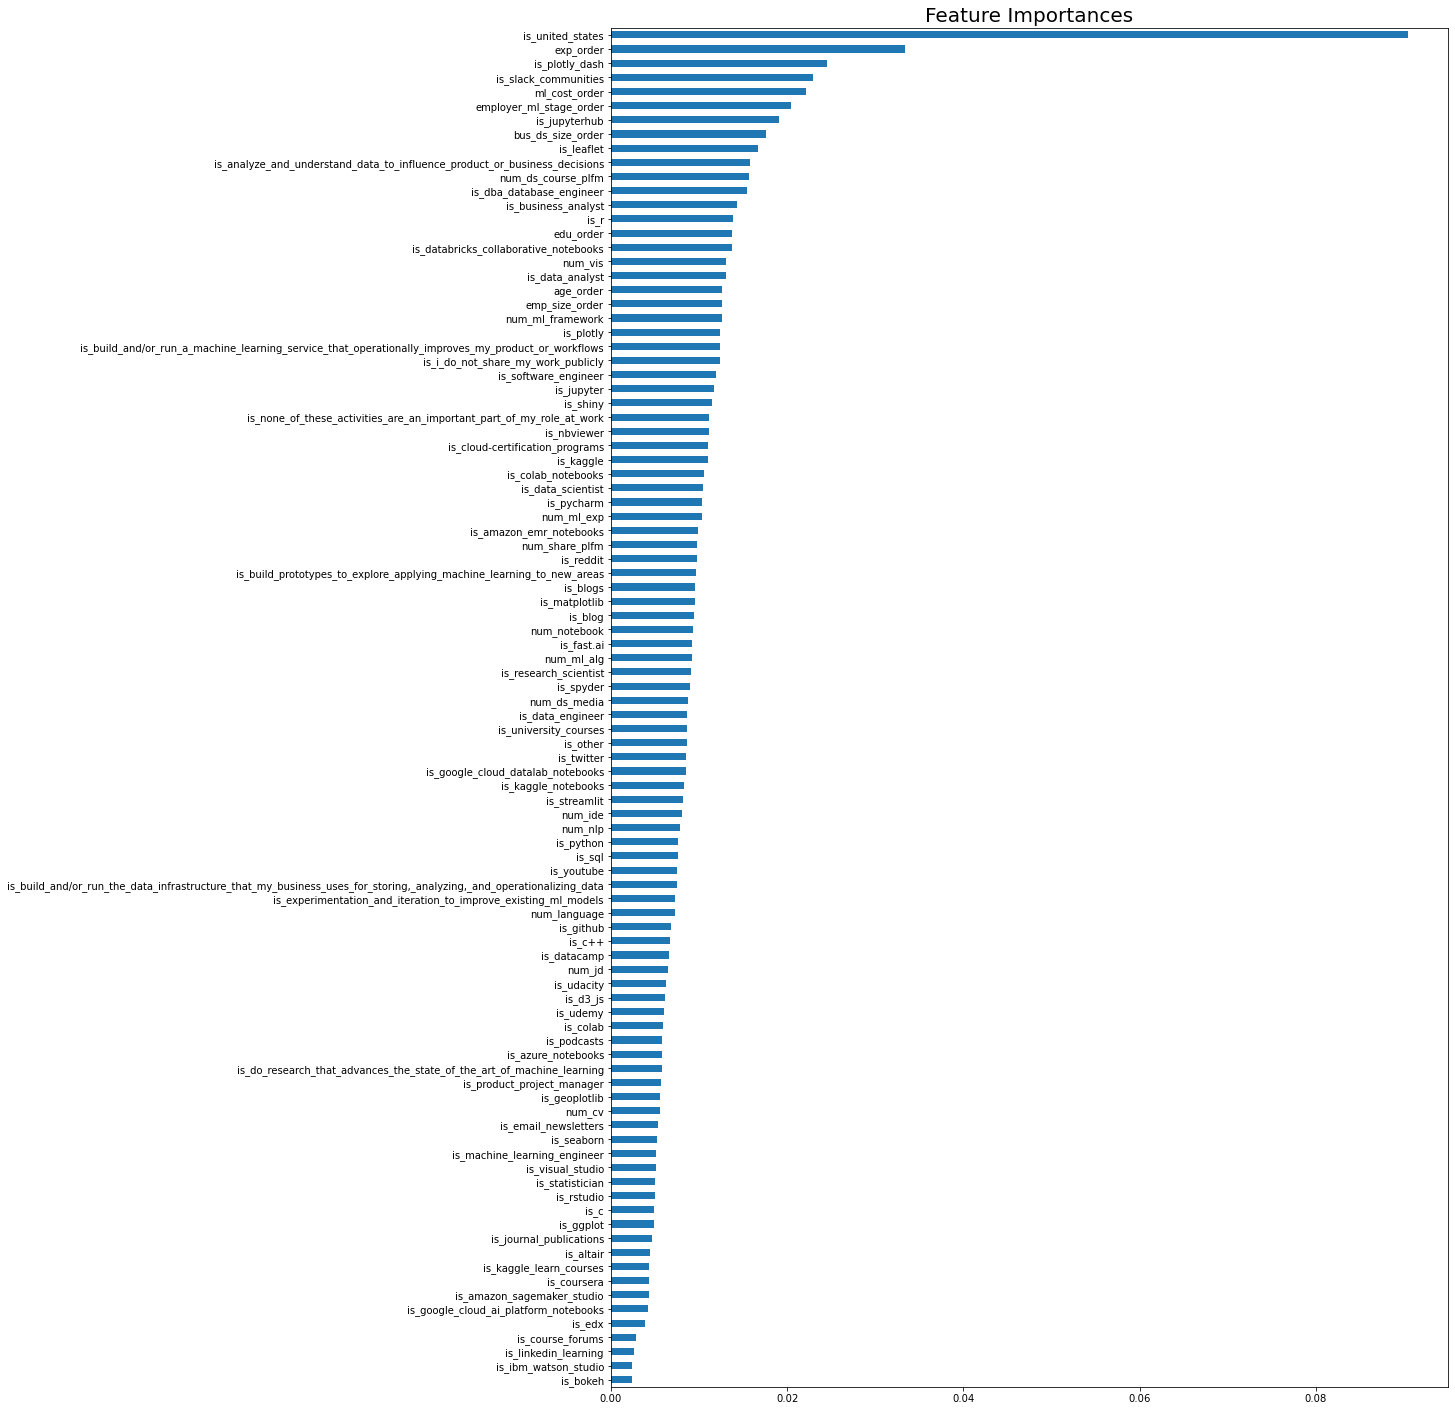

In [59]:
plt.figure(figsize=(15, 25))
plt.title("Feature Importances", fontsize=20)
pd.Series(model.feature_importances_, index=X_col_list).sort_values().plot(kind='barh');

#### 2. Feature Importance with Permutation
#### Great 👍🏼! It gives us a clearer trend of what are the more important features:
    * personal attributes: 'is_united_states', 'age_order', 'edu_order', 
    * skillsets & abilities: 'num_ide', 'num_language', 'num_vis', 'num_ml_framework'
    * career experiences: 'ml_cost_order', 'exp_order', 'num_ml_exp', 'bus_ds_size_order', 'employer_ml_stage_order', 'num_ml_alg'
    * continuous growths: 'num_ds_course_plfm', 'num_share_plfm'

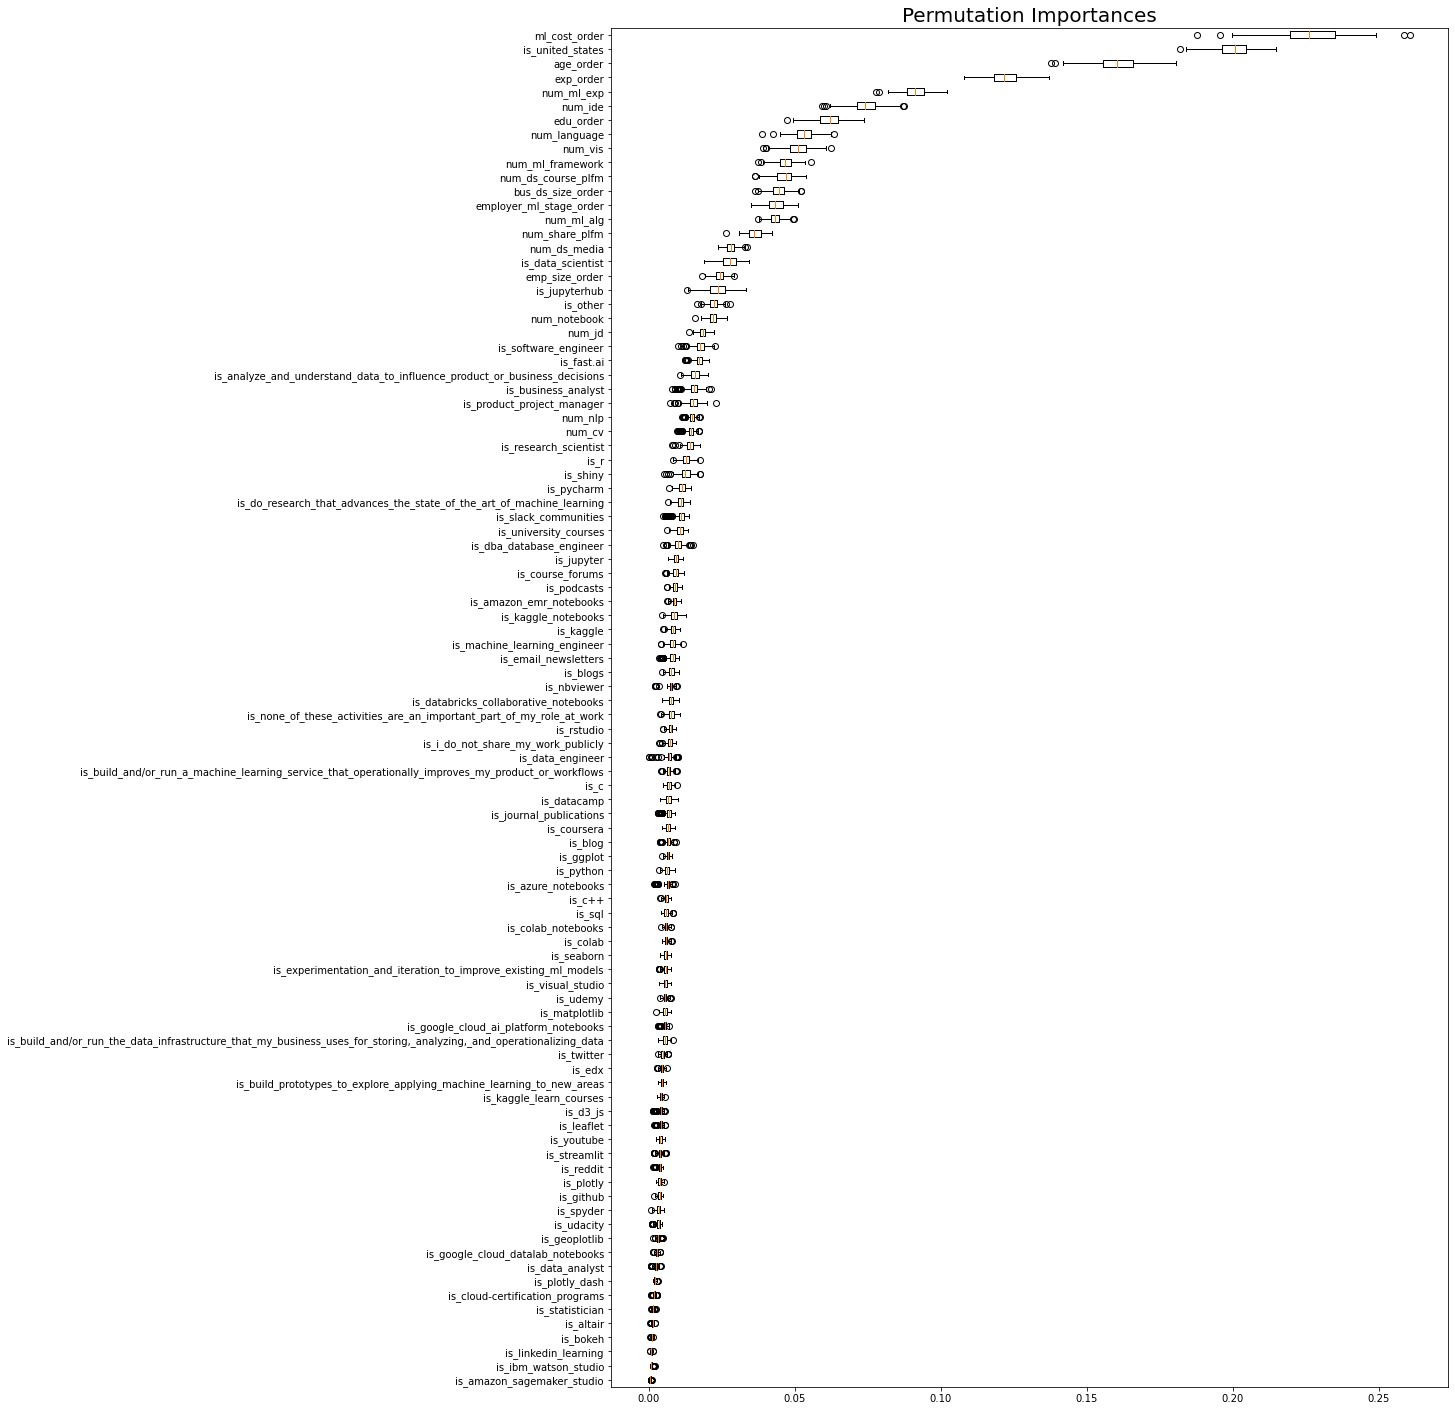

In [60]:
perm = permutation_importance(model, 
                              X=df[X_col_list],
                              y=df['comp_order'],
                              n_repeats=300,
                              random_state=422)

sorted_idx = perm.importances_mean.argsort()

plt.figure(figsize=(15, 25))
plt.boxplot(perm.importances[sorted_idx].T, vert=False, labels=df[X_col_list].columns[sorted_idx])
plt.title("Permutation Importances", fontsize=20)
plt.show()